In [1]:
import numpy as np
import cv2
import glob
import time

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from skimage.feature import hog

from scipy.ndimage.measurements import label

from helperfunctions import *

In [2]:
# Read in cars and notcars
cars = glob.glob('data/vehicles/*/*.png')
notcars = glob.glob('data/non-vehicles/*/*.png')

# Check that arrays are not empty
print(cars[0])
print(notcars[0])

print(len(cars))
print(len(notcars))

data/vehicles/GTI_Far/image0000.png
data/non-vehicles/Extras/extra1.png
8792
8968


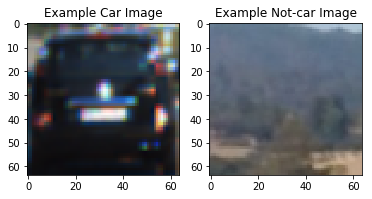

In [4]:
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

In [3]:

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 5  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 5 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 24    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
xy_window_size = (64, 64)
xy_overlap_size = (0.5, 0.5)

y_start_stop = [400, 720] # Min and max in y to search in slide_window()

# Parameters below for saving data for future reference
image_file_name = "hogviz/" + str(color_space) + "_ss" + str(spatial_size[0]) + str(spatial_size[1]) + "_hb" + str(hist_bins) + "_TTT_" + "o" + str(orient) \
                    + "_ppc" + str(pix_per_cell) + "_cpb" \
                    + str(cell_per_block) + "_hc" + str(hog_channel) + "_wdw" \
                    #+ str(xy_window_size[0]) + str(xy_window_size[1]) + "_olp" \
                    #+ str(xy_overlap_size[0]) + str(xy_overlap_size[1])
image_title = str(pix_per_cell) + "ppc"
logfilepath = "logs/hogviz_experiments/ppc_exp1.md"

sample_car = [cars[42]]
sample_notcar = [notcars[42]]



[array([ 0.0064333 ,  0.00218015,  0.03976307, ...,  0.01063966,
         0.0025812 ,  0.00358203])]

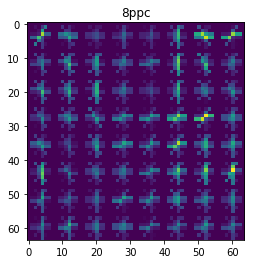

In [4]:
# Plot HOG visualisation
'''
extract_features(sample_car, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
'''


extract_features_plot(sample_car, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,
                        viz=True, viz_only=True, viz_title=image_title, hog_viz_name=image_file_name)

In [5]:
# Extract features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Normalise input
X = normalise(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=42)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 5 orientations 8 pixels per cell and 5 cells per block
Feature vector length: 6000


In [6]:
'''
train a linear SVC
'''
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
training_time = round(t2-t, 4)
print(training_time, 'Seconds to train SVC...')
# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 8)
print('Test Accuracy of SVC = ', svc_score)
# Check the prediction time for a single sample
t=time.time()

# Log training parameters and results

with open(logfilepath, "a") as f:
    f.write("\n\n" + str(image_file_name))
    f.write("\nParameters:")
    f.write("\ncolor_space: " + str(color_space))
    f.write("\norient: " + str(orient))
    f.write("\npix_per_cell: " + str(pix_per_cell))
    f.write("\ncell_per_block: " + str(cell_per_block))
    f.write("\nhog_channel: " + str(hog_channel))
    f.write("\nspatial_size: " + str(spatial_size))
    f.write("\nhist_bins: " + str(hist_bins))
    f.write("\nspatial_feat: " + str(spatial_feat))
    f.write("\nhist_feat: " + str(hist_feat))
    f.write("\nhog_feat: " + str(hog_feat))
    f.write('\nFeature vector length:' + str(len(X_train[0])))
    f.write("\n" + str(training_time) + 'Seconds to train SVC...')
    f.write('\nTest Accuracy of SVC = ' + str(svc_score))

print("\nParameters:")
print("color_space: ", color_space)
print("orient: ", orient)
print("pix_per_cell: ", pix_per_cell)
print("cell_per_block: ", cell_per_block)
print("hog_channel: ", hog_channel)
print("spatial_size: ", spatial_size)
print("hist_bins: ", hist_bins)
print("spatial_feat: ", spatial_feat)
print("hist_feat: ", hist_feat)
print("hog_feat: ", hog_feat)

24.652 Seconds to train SVC...
Test Accuracy of SVC =  0.96593468

Parameters:
color_space:  YCrCb
orient:  5
pix_per_cell:  8
cell_per_block:  5
hog_channel:  ALL
spatial_size:  (16, 16)
hist_bins:  24
spatial_feat:  False
hist_feat:  False
hog_feat:  True


In [32]:
def create_heatmaps(all_bboxes, recent_frames_used=20, threshold=5):
    """
    Produces a heatmap for each frame in `all_bboxes` and returns
    an array of heatmaps.
    `all_bboxes` is an array of arrays of bboxes.
    Each element represents a frame. Each element is an array of bboxes found in
    that frame."""
    heatmap_list = []

    for idx, boxlist in enumerate(all_bboxes):
        # Produce heatmap for the most recent e.g. 10 frames:
        # print("Boxlist: ", boxlist)
        idx_start = max(idx - recent_frames_used, 0)
        idx_heatmap = heatmap_template
        for boxlist2 in all_bboxes[idx_start:idx + 1]:
            idx_heatmap = add_heat(idx_heatmap, boxlist2)
            # print("Boxlist2: ", boxlist2)

        # Apply threshold
        idx_heatmap = apply_threshold(idx_heatmap, threshold)

        # Add heatmap to list of heatmaps
        heatmap_list.append(idx_heatmap)
        plt.imshow(idx_heatmap, cmap="hot")

        # Don't know what this is for:
        # final_map = np.clip(heat - 2, 0, 255)
    return heatmap_list

In [33]:
'''
Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
'''

def draw_on_image(testimage_number):
    # Read in image
    image = mpimg.imread('test_images/test' + str(testimage_number) + '.jpg')
    draw_image = np.copy(image)

    # Rescale data since training data extracted from 
    # .png images (scaled 0 to 1 by mpimg) and image we
    # are searching is .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    
    # Normalise image
    # image = normalise(image)
    # print(image, image.shape)
    
    # Get list of windows to search at this stage.
    windows = slide_window_polygonmask(image, x_start_stop=[600, 1280], y_start_stop=y_start_stop, 
                        xy_window=xy_window_size, xy_overlap=xy_overlap_size, polygon_mask=mask)

    # Return all the windows the classifier has predicted contain car(s) ('positive windows').
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    # Draw bounding boxes around the windows that the classifier predicted has cars in them
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

    # Plot image with bounding boxes drawn.
    plt.title(image_title)
    plt.imshow(window_img)
    plt.savefig(image_file_name + "_window_test" + str(testimage_number) + ".png")
    
    hot_img = create_heatmaps(hot_windows)
    
    # Plot image with bounding boxes drawn.
    plt.title(image_title+"hot")
    plt.imshow(hot_img)
    plt.savefig(image_file_name + "_hot_test" + str(testimage_number) + ".png")

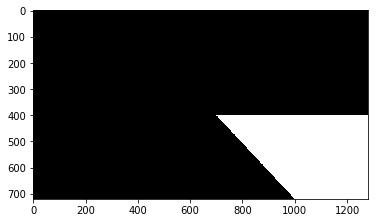

In [34]:
mask = np.zeros_like(mpimg.imread('test_images/test1.jpg')[:,:,0])
vertices = np.array([[(700,400),(1000,720),(1280,720),(1280,400)]])
mask = cv2.fillPoly(mask, vertices, 1)
plt.imshow(mask, cmap="gray")

In [35]:
windows = slide_window_polygonmask(image, x_start_stop=[600, 1280], y_start_stop=y_start_stop, 
                        xy_window=xy_window_size, xy_overlap=xy_overlap_size, polygon_mask=mask)

TypeError: 'int' object is not subscriptable

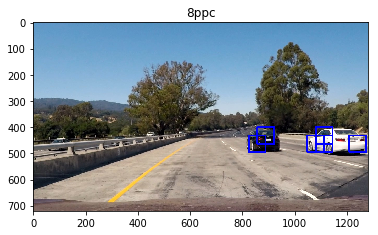

In [36]:
draw_on_image(1)

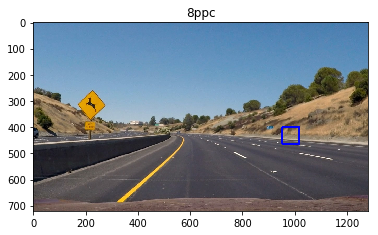

In [16]:
draw_on_image(2)

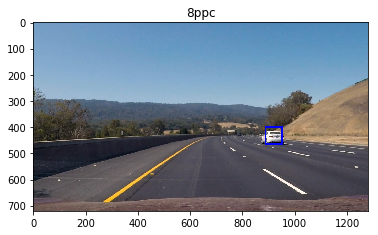

In [17]:
draw_on_image(3)

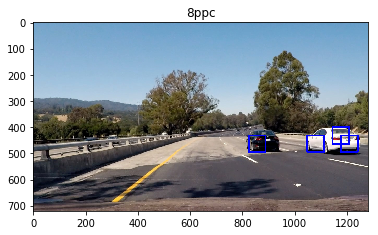

In [18]:
draw_on_image(4)

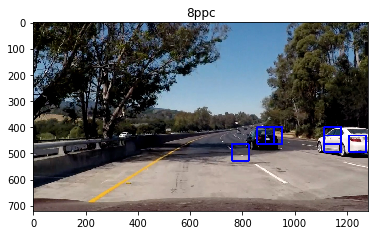

In [19]:
draw_on_image(5)

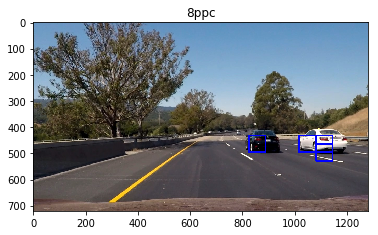

In [20]:
draw_on_image(6)

In [21]:
'''
Run your pipeline on a video stream and create a heat map of recurring detections frame 
by frame to reject outliers and follow detected vehicles.
'''
def add_bboxes(input_image, windows, classifier, scaler, draw=True, bboxes_only=False):
    """Adds bounding boxes from `input_image` (one array of arrays) to
    the global variable `bboxes_list`'.
    If `draw` is True, returns image overlaid with bounding boxes.
    """
    global bboxes_list
    
    # Normalise image
    # input_image = normalise(input_image)
    
    hot_windows = search_windows(input_image, windows, classifier, scaler, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
    print("Hot windows: ", hot_windows)
    bboxes_list.append(hot_windows)
    if draw == True:
        draw_image = np.copy(input_image)
        window_img = draw_boxes(input_image, hot_windows, color=(0, 0, 255), thick=6)
        return window_img

In [22]:
#Convert image pipeline into video pipeline

def add_bboxes_to_list(image):
    """Adds bounding boxes in `image` to global `bboxes_list`.
    Returns image with bounding boxes drawn.
    """
    return add_bboxes(image, windows, svc, X_scaler)

In [23]:
#Create heat map

def add_heat(heatmap, box_list):
    """Returns `heatmap` with bounding boxes in `bbox_list` added to it.
    `bbox_list` is an array of boxes.

    This function should be applied per frame.
    """
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [24]:
#Estimate a bounding box for vehicles detected

def draw_filtered_bboxes(image, all_bboxes, recent_frames_used=20, threshold=5): 
    """`all_bboxes` is an array of arrays of bboxes.
    Each element represents a frame. Each element is an array of bboxes found in
    that frame."""
    
    # Add bounding boxes from this frame
    add_bboxes(image, windows, svc, X_scaler, draw=False)
    
    # Adjust parameters if needed
    if len(all_bboxes) < recent_frames_used + 1:
        recent_frames_used = len(all_bboxes) - 1    
    
    # Prepare heatmap template
    frame_heatmap = np.zeros_like(image[:,:,0])
    
    # Construct heatmap
    for boxlist in all_bboxes[-recent_frames_used:]:
        frame_heatmap = add_heat(frame_heatmap, boxlist)
    
    # Apply threshold
    frame_heatmap = apply_threshold(frame_heatmap, threshold)
    
    # Label regions
    labels = label(frame_heatmap)
    
    # Draw bounding boxes around labelled regions
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    plt.imshow(draw_img)
    return draw_img

In [25]:
def process_image(image):
    global bboxes_list    
    
    return draw_filtered_bboxes(image, bboxes_list)

Hot windows:  []
[MoviePy] >>>> Building video output_v5.mp4
[MoviePy] Writing video output_v5.mp4


  0%|          | 1/1261 [00:00<10:25,  2.02it/s]

Hot windows:  []


  0%|          | 2/1261 [00:01<10:33,  1.99it/s]

Hot windows:  []


  0%|          | 3/1261 [00:01<10:27,  2.00it/s]

Hot windows:  []


  0%|          | 4/1261 [00:02<10:47,  1.94it/s]

Hot windows:  []


  0%|          | 5/1261 [00:02<11:04,  1.89it/s]

Hot windows:  []


  0%|          | 6/1261 [00:03<10:45,  1.95it/s]

Hot windows:  []


  1%|          | 7/1261 [00:03<10:57,  1.91it/s]

Hot windows:  []


  1%|          | 8/1261 [00:04<10:39,  1.96it/s]

Hot windows:  []


  1%|          | 9/1261 [00:04<10:31,  1.98it/s]

Hot windows:  []


  1%|          | 10/1261 [00:05<10:18,  2.02it/s]

Hot windows:  []


  1%|          | 11/1261 [00:05<10:03,  2.07it/s]

Hot windows:  []


  1%|          | 12/1261 [00:06<09:54,  2.10it/s]

Hot windows:  []


  1%|          | 13/1261 [00:06<09:44,  2.13it/s]

Hot windows:  []


  1%|          | 14/1261 [00:06<09:43,  2.14it/s]

Hot windows:  []


  1%|          | 15/1261 [00:07<09:52,  2.10it/s]

Hot windows:  []


  1%|▏         | 16/1261 [00:07<09:46,  2.12it/s]

Hot windows:  []


  1%|▏         | 17/1261 [00:08<09:54,  2.09it/s]

Hot windows:  []


  1%|▏         | 18/1261 [00:08<09:51,  2.10it/s]

Hot windows:  []


  2%|▏         | 19/1261 [00:09<09:42,  2.13it/s]

Hot windows:  []


  2%|▏         | 20/1261 [00:09<09:39,  2.14it/s]

Hot windows:  []


  2%|▏         | 21/1261 [00:10<09:38,  2.14it/s]

Hot windows:  []


  2%|▏         | 22/1261 [00:10<09:46,  2.11it/s]

Hot windows:  []


  2%|▏         | 23/1261 [00:11<09:40,  2.13it/s]

Hot windows:  []


  2%|▏         | 24/1261 [00:11<09:41,  2.13it/s]

Hot windows:  []


  2%|▏         | 25/1261 [00:12<09:52,  2.08it/s]

Hot windows:  []


  2%|▏         | 26/1261 [00:12<09:47,  2.10it/s]

Hot windows:  []


  2%|▏         | 27/1261 [00:13<09:46,  2.10it/s]

Hot windows:  []


  2%|▏         | 28/1261 [00:13<09:42,  2.12it/s]

Hot windows:  []


  2%|▏         | 29/1261 [00:14<09:38,  2.13it/s]

Hot windows:  []


  2%|▏         | 30/1261 [00:14<09:32,  2.15it/s]

Hot windows:  []


  2%|▏         | 31/1261 [00:14<09:32,  2.15it/s]

Hot windows:  []


  3%|▎         | 32/1261 [00:15<09:30,  2.15it/s]

Hot windows:  []


  3%|▎         | 33/1261 [00:15<09:27,  2.16it/s]

Hot windows:  []


  3%|▎         | 34/1261 [00:16<09:25,  2.17it/s]

Hot windows:  []


  3%|▎         | 35/1261 [00:16<09:30,  2.15it/s]

Hot windows:  []


  3%|▎         | 36/1261 [00:17<10:08,  2.01it/s]

Hot windows:  []


  3%|▎         | 37/1261 [00:17<09:53,  2.06it/s]

Hot windows:  []


  3%|▎         | 38/1261 [00:18<09:45,  2.09it/s]

Hot windows:  []


  3%|▎         | 39/1261 [00:18<09:36,  2.12it/s]

Hot windows:  []


  3%|▎         | 40/1261 [00:19<09:33,  2.13it/s]

Hot windows:  []


  3%|▎         | 41/1261 [00:19<09:25,  2.16it/s]

Hot windows:  []


  3%|▎         | 42/1261 [00:20<09:26,  2.15it/s]

Hot windows:  [((952, 624), (1016, 688))]


  3%|▎         | 43/1261 [00:20<09:29,  2.14it/s]

Hot windows:  []


  3%|▎         | 44/1261 [00:21<09:34,  2.12it/s]

Hot windows:  []


  4%|▎         | 45/1261 [00:21<09:47,  2.07it/s]

Hot windows:  []


  4%|▎         | 46/1261 [00:22<10:43,  1.89it/s]

Hot windows:  []


  4%|▎         | 47/1261 [00:22<10:13,  1.98it/s]

Hot windows:  []


  4%|▍         | 48/1261 [00:23<10:02,  2.01it/s]

Hot windows:  []


  4%|▍         | 49/1261 [00:23<09:48,  2.06it/s]

Hot windows:  []


  4%|▍         | 50/1261 [00:24<09:52,  2.05it/s]

Hot windows:  []


  4%|▍         | 51/1261 [00:24<09:53,  2.04it/s]

Hot windows:  []


  4%|▍         | 52/1261 [00:25<11:14,  1.79it/s]

Hot windows:  []


  4%|▍         | 53/1261 [00:25<10:51,  1.85it/s]

Hot windows:  []


  4%|▍         | 54/1261 [00:26<11:05,  1.81it/s]

Hot windows:  []


  4%|▍         | 55/1261 [00:26<11:14,  1.79it/s]

Hot windows:  []


  4%|▍         | 56/1261 [00:27<11:46,  1.71it/s]

Hot windows:  []


  5%|▍         | 57/1261 [00:28<11:40,  1.72it/s]

Hot windows:  []


  5%|▍         | 58/1261 [00:28<11:22,  1.76it/s]

Hot windows:  []


  5%|▍         | 59/1261 [00:29<11:00,  1.82it/s]

Hot windows:  []


  5%|▍         | 60/1261 [00:29<10:46,  1.86it/s]

Hot windows:  []


  5%|▍         | 61/1261 [00:30<11:09,  1.79it/s]

Hot windows:  []


  5%|▍         | 62/1261 [00:30<10:53,  1.83it/s]

Hot windows:  []


  5%|▍         | 63/1261 [00:31<10:29,  1.90it/s]

Hot windows:  []


  5%|▌         | 64/1261 [00:31<10:39,  1.87it/s]

Hot windows:  []


  5%|▌         | 65/1261 [00:32<10:49,  1.84it/s]

Hot windows:  []


  5%|▌         | 66/1261 [00:32<10:45,  1.85it/s]

Hot windows:  []


  5%|▌         | 67/1261 [00:33<10:33,  1.88it/s]

Hot windows:  []


  5%|▌         | 68/1261 [00:33<10:13,  1.94it/s]

Hot windows:  []


  5%|▌         | 69/1261 [00:34<10:11,  1.95it/s]

Hot windows:  []


  6%|▌         | 70/1261 [00:34<09:56,  2.00it/s]

Hot windows:  []


  6%|▌         | 71/1261 [00:35<09:55,  2.00it/s]

Hot windows:  []


  6%|▌         | 72/1261 [00:36<10:48,  1.83it/s]

Hot windows:  []


  6%|▌         | 73/1261 [00:36<10:26,  1.90it/s]

Hot windows:  []


  6%|▌         | 74/1261 [00:37<10:18,  1.92it/s]

Hot windows:  []


  6%|▌         | 75/1261 [00:37<10:30,  1.88it/s]

Hot windows:  []


  6%|▌         | 76/1261 [00:38<10:44,  1.84it/s]

Hot windows:  []


  6%|▌         | 77/1261 [00:38<11:17,  1.75it/s]

Hot windows:  []


  6%|▌         | 78/1261 [00:39<11:44,  1.68it/s]

Hot windows:  []


  6%|▋         | 79/1261 [00:40<11:56,  1.65it/s]

Hot windows:  []


  6%|▋         | 80/1261 [00:40<11:43,  1.68it/s]

Hot windows:  []


  6%|▋         | 81/1261 [00:41<11:37,  1.69it/s]

Hot windows:  []


  7%|▋         | 82/1261 [00:41<11:30,  1.71it/s]

Hot windows:  []


  7%|▋         | 83/1261 [00:42<11:04,  1.77it/s]

Hot windows:  []


  7%|▋         | 84/1261 [00:42<10:44,  1.83it/s]

Hot windows:  []


  7%|▋         | 85/1261 [00:43<10:22,  1.89it/s]

Hot windows:  []


  7%|▋         | 86/1261 [00:43<10:08,  1.93it/s]

Hot windows:  [((920, 400), (984, 464))]


  7%|▋         | 87/1261 [00:44<09:55,  1.97it/s]

Hot windows:  []


  7%|▋         | 88/1261 [00:44<09:47,  2.00it/s]

Hot windows:  []


  7%|▋         | 89/1261 [00:45<10:08,  1.93it/s]

Hot windows:  []


  7%|▋         | 90/1261 [00:45<10:09,  1.92it/s]

Hot windows:  []


  7%|▋         | 91/1261 [00:46<10:17,  1.90it/s]

Hot windows:  [((1144, 656), (1208, 720))]


  7%|▋         | 92/1261 [00:46<10:05,  1.93it/s]

Hot windows:  [((1144, 656), (1208, 720))]


  7%|▋         | 93/1261 [00:47<10:26,  1.86it/s]

Hot windows:  [((1144, 656), (1208, 720))]


  7%|▋         | 94/1261 [00:48<11:22,  1.71it/s]

Hot windows:  [((1144, 656), (1208, 720))]


  8%|▊         | 95/1261 [00:48<11:06,  1.75it/s]

Hot windows:  [((1144, 656), (1208, 720))]


  8%|▊         | 96/1261 [00:49<10:50,  1.79it/s]

Hot windows:  [((1144, 656), (1208, 720))]


  8%|▊         | 97/1261 [00:49<10:58,  1.77it/s]

Hot windows:  [((984, 400), (1048, 464))]


  8%|▊         | 98/1261 [00:50<11:15,  1.72it/s]

Hot windows:  []


  8%|▊         | 99/1261 [00:51<11:13,  1.73it/s]

Hot windows:  []


  8%|▊         | 100/1261 [00:51<10:57,  1.77it/s]

Hot windows:  []


  8%|▊         | 101/1261 [00:52<10:47,  1.79it/s]

Hot windows:  [((1144, 656), (1208, 720))]


  8%|▊         | 102/1261 [00:52<10:42,  1.80it/s]

Hot windows:  [((1144, 656), (1208, 720))]


  8%|▊         | 103/1261 [00:53<10:33,  1.83it/s]

Hot windows:  [((1144, 656), (1208, 720))]


  8%|▊         | 104/1261 [00:53<10:22,  1.86it/s]

Hot windows:  [((920, 624), (984, 688)), ((1144, 656), (1208, 720))]


  8%|▊         | 105/1261 [00:54<10:23,  1.85it/s]

Hot windows:  []


  8%|▊         | 106/1261 [00:54<10:04,  1.91it/s]

Hot windows:  []


  8%|▊         | 107/1261 [00:55<09:58,  1.93it/s]

Hot windows:  []


  9%|▊         | 108/1261 [00:55<09:51,  1.95it/s]

Hot windows:  []


  9%|▊         | 109/1261 [00:56<09:38,  1.99it/s]

Hot windows:  []


  9%|▊         | 110/1261 [00:56<09:21,  2.05it/s]

Hot windows:  []


  9%|▉         | 111/1261 [00:57<09:17,  2.06it/s]

Hot windows:  []


  9%|▉         | 112/1261 [00:57<09:12,  2.08it/s]

Hot windows:  []


  9%|▉         | 113/1261 [00:58<09:22,  2.04it/s]

Hot windows:  [((856, 560), (920, 624)), ((888, 592), (952, 656))]


  9%|▉         | 114/1261 [00:58<09:11,  2.08it/s]

Hot windows:  []


  9%|▉         | 115/1261 [00:59<09:11,  2.08it/s]

Hot windows:  []


  9%|▉         | 116/1261 [00:59<09:03,  2.11it/s]

Hot windows:  []


  9%|▉         | 117/1261 [01:00<08:55,  2.14it/s]

Hot windows:  []


  9%|▉         | 118/1261 [01:00<09:07,  2.09it/s]

Hot windows:  []


  9%|▉         | 119/1261 [01:00<09:00,  2.11it/s]

Hot windows:  [((1176, 592), (1240, 656))]


 10%|▉         | 120/1261 [01:01<09:26,  2.01it/s]

Hot windows:  []


 10%|▉         | 121/1261 [01:02<09:25,  2.01it/s]

Hot windows:  []


 10%|▉         | 122/1261 [01:02<09:57,  1.91it/s]

Hot windows:  []


 10%|▉         | 123/1261 [01:03<09:44,  1.95it/s]

Hot windows:  []


 10%|▉         | 124/1261 [01:03<09:25,  2.01it/s]

Hot windows:  []


 10%|▉         | 125/1261 [01:04<09:43,  1.95it/s]

Hot windows:  []


 10%|▉         | 126/1261 [01:04<09:36,  1.97it/s]

Hot windows:  [((1016, 400), (1080, 464))]


 10%|█         | 127/1261 [01:05<09:23,  2.01it/s]

Hot windows:  [((1016, 400), (1080, 464))]


 10%|█         | 128/1261 [01:05<09:14,  2.04it/s]

Hot windows:  []


 10%|█         | 129/1261 [01:06<09:19,  2.02it/s]

Hot windows:  []


 10%|█         | 130/1261 [01:06<09:12,  2.05it/s]

Hot windows:  []


 10%|█         | 131/1261 [01:07<09:12,  2.04it/s]

Hot windows:  [((1048, 400), (1112, 464))]


 10%|█         | 132/1261 [01:07<09:03,  2.08it/s]

Hot windows:  []


 11%|█         | 133/1261 [01:07<09:06,  2.06it/s]

Hot windows:  []


 11%|█         | 134/1261 [01:08<09:12,  2.04it/s]

Hot windows:  []


 11%|█         | 135/1261 [01:08<09:11,  2.04it/s]

Hot windows:  []


 11%|█         | 136/1261 [01:09<09:22,  2.00it/s]

Hot windows:  []


 11%|█         | 137/1261 [01:10<09:18,  2.01it/s]

Hot windows:  []


 11%|█         | 138/1261 [01:10<09:05,  2.06it/s]

Hot windows:  [((1048, 400), (1112, 464))]


 11%|█         | 139/1261 [01:10<08:58,  2.08it/s]

Hot windows:  []


 11%|█         | 140/1261 [01:11<08:57,  2.08it/s]

Hot windows:  []


 11%|█         | 141/1261 [01:11<08:56,  2.09it/s]

Hot windows:  []


 11%|█▏        | 142/1261 [01:12<08:52,  2.10it/s]

Hot windows:  []


 11%|█▏        | 143/1261 [01:12<08:58,  2.08it/s]

Hot windows:  []


 11%|█▏        | 144/1261 [01:13<08:52,  2.10it/s]

Hot windows:  []


 11%|█▏        | 145/1261 [01:13<08:48,  2.11it/s]

Hot windows:  []


 12%|█▏        | 146/1261 [01:14<11:20,  1.64it/s]

Hot windows:  []


 12%|█▏        | 147/1261 [01:15<11:10,  1.66it/s]

Hot windows:  []


 12%|█▏        | 148/1261 [01:15<10:41,  1.74it/s]

Hot windows:  []


 12%|█▏        | 149/1261 [01:16<10:03,  1.84it/s]

Hot windows:  []


 12%|█▏        | 150/1261 [01:16<09:47,  1.89it/s]

Hot windows:  []


 12%|█▏        | 151/1261 [01:17<09:43,  1.90it/s]

Hot windows:  []


 12%|█▏        | 152/1261 [01:17<09:34,  1.93it/s]

Hot windows:  []


 12%|█▏        | 153/1261 [01:18<09:55,  1.86it/s]

Hot windows:  []


 12%|█▏        | 154/1261 [01:18<09:37,  1.92it/s]

Hot windows:  []


 12%|█▏        | 155/1261 [01:19<09:22,  1.97it/s]

Hot windows:  [((888, 592), (952, 656))]


 12%|█▏        | 156/1261 [01:19<09:11,  2.00it/s]

Hot windows:  []


 12%|█▏        | 157/1261 [01:20<09:13,  1.99it/s]

Hot windows:  []


 13%|█▎        | 158/1261 [01:20<09:07,  2.02it/s]

Hot windows:  []


 13%|█▎        | 159/1261 [01:21<08:50,  2.08it/s]

Hot windows:  [((1208, 400), (1272, 464))]


 13%|█▎        | 160/1261 [01:21<08:40,  2.11it/s]

Hot windows:  [((1208, 400), (1272, 464)), ((1208, 432), (1272, 496))]


 13%|█▎        | 161/1261 [01:22<08:37,  2.12it/s]

Hot windows:  [((1208, 400), (1272, 464))]


 13%|█▎        | 162/1261 [01:22<08:40,  2.11it/s]

Hot windows:  [((1208, 400), (1272, 464))]


 13%|█▎        | 163/1261 [01:23<09:05,  2.01it/s]

Hot windows:  [((1208, 400), (1272, 464))]


 13%|█▎        | 164/1261 [01:23<08:52,  2.06it/s]

Hot windows:  [((1208, 400), (1272, 464))]


 13%|█▎        | 165/1261 [01:24<09:09,  1.99it/s]

Hot windows:  [((1208, 400), (1272, 464))]


 13%|█▎        | 166/1261 [01:24<08:57,  2.04it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((1208, 400), (1272, 464)), ((1144, 432), (1208, 496))]


 13%|█▎        | 167/1261 [01:25<08:48,  2.07it/s]

Hot windows:  []


 13%|█▎        | 168/1261 [01:25<08:41,  2.10it/s]

Hot windows:  [((1080, 432), (1144, 496))]


 13%|█▎        | 169/1261 [01:26<08:37,  2.11it/s]

Hot windows:  []


 13%|█▎        | 170/1261 [01:26<08:30,  2.14it/s]

Hot windows:  [((1176, 400), (1240, 464))]


 14%|█▎        | 171/1261 [01:26<08:23,  2.16it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((1144, 432), (1208, 496))]


 14%|█▎        | 172/1261 [01:27<08:26,  2.15it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((1144, 432), (1208, 496))]


 14%|█▎        | 173/1261 [01:27<08:24,  2.15it/s]

Hot windows:  [((1176, 400), (1240, 464))]


 14%|█▍        | 174/1261 [01:28<08:31,  2.13it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((1048, 432), (1112, 496))]


 14%|█▍        | 175/1261 [01:28<08:25,  2.15it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((1048, 432), (1112, 496))]


 14%|█▍        | 176/1261 [01:29<08:28,  2.13it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((1048, 432), (1112, 496))]


 14%|█▍        | 177/1261 [01:29<08:22,  2.16it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((1048, 432), (1112, 496))]


 14%|█▍        | 178/1261 [01:30<08:22,  2.16it/s]

Hot windows:  []


 14%|█▍        | 179/1261 [01:30<08:28,  2.13it/s]

Hot windows:  []


 14%|█▍        | 180/1261 [01:31<08:25,  2.14it/s]

Hot windows:  []


 14%|█▍        | 181/1261 [01:31<08:20,  2.16it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 14%|█▍        | 182/1261 [01:32<08:24,  2.14it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 15%|█▍        | 183/1261 [01:32<08:15,  2.17it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 15%|█▍        | 184/1261 [01:33<08:22,  2.14it/s]

Hot windows:  []


 15%|█▍        | 185/1261 [01:33<08:23,  2.14it/s]

Hot windows:  [((1144, 400), (1208, 464))]


 15%|█▍        | 186/1261 [01:33<08:25,  2.13it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((1048, 432), (1112, 496))]


 15%|█▍        | 187/1261 [01:34<08:27,  2.12it/s]

Hot windows:  [((1144, 400), (1208, 464))]


 15%|█▍        | 188/1261 [01:34<08:18,  2.15it/s]

Hot windows:  [((1144, 400), (1208, 464))]


 15%|█▍        | 189/1261 [01:35<08:16,  2.16it/s]

Hot windows:  [((1144, 400), (1208, 464))]


 15%|█▌        | 190/1261 [01:35<08:17,  2.15it/s]

Hot windows:  [((1144, 400), (1208, 464))]


 15%|█▌        | 191/1261 [01:36<08:35,  2.08it/s]

Hot windows:  [((1144, 400), (1208, 464))]


 15%|█▌        | 192/1261 [01:36<08:30,  2.09it/s]

Hot windows:  [((1144, 400), (1208, 464))]


 15%|█▌        | 193/1261 [01:37<08:25,  2.11it/s]

Hot windows:  [((1144, 400), (1208, 464))]


 15%|█▌        | 194/1261 [01:37<08:18,  2.14it/s]

Hot windows:  []


 15%|█▌        | 195/1261 [01:38<08:36,  2.06it/s]

Hot windows:  []


 16%|█▌        | 196/1261 [01:38<08:33,  2.07it/s]

Hot windows:  []


 16%|█▌        | 197/1261 [01:39<08:27,  2.10it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 16%|█▌        | 198/1261 [01:39<08:22,  2.12it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 16%|█▌        | 199/1261 [01:40<08:20,  2.12it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 16%|█▌        | 200/1261 [01:40<08:19,  2.13it/s]

Hot windows:  []


 16%|█▌        | 201/1261 [01:41<08:16,  2.13it/s]

Hot windows:  []


 16%|█▌        | 202/1261 [01:41<08:22,  2.11it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1208, 464), (1272, 528))]


 16%|█▌        | 203/1261 [01:42<08:16,  2.13it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1208, 464), (1272, 528))]


 16%|█▌        | 204/1261 [01:42<08:28,  2.08it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1208, 464), (1272, 528))]


 16%|█▋        | 205/1261 [01:42<08:22,  2.10it/s]

Hot windows:  [((1112, 400), (1176, 464))]


 16%|█▋        | 206/1261 [01:43<08:23,  2.09it/s]

Hot windows:  [((1112, 400), (1176, 464))]


 16%|█▋        | 207/1261 [01:43<08:18,  2.11it/s]

Hot windows:  [((1112, 400), (1176, 464))]


 16%|█▋        | 208/1261 [01:44<08:23,  2.09it/s]

Hot windows:  [((1112, 400), (1176, 464))]


 17%|█▋        | 209/1261 [01:44<08:19,  2.10it/s]

Hot windows:  [((1112, 400), (1176, 464))]


 17%|█▋        | 210/1261 [01:45<08:26,  2.07it/s]

Hot windows:  [((1112, 400), (1176, 464))]


 17%|█▋        | 211/1261 [01:45<08:20,  2.10it/s]

Hot windows:  [((1112, 400), (1176, 464))]


 17%|█▋        | 212/1261 [01:46<08:19,  2.10it/s]

Hot windows:  [((1112, 400), (1176, 464))]


 17%|█▋        | 213/1261 [01:46<08:10,  2.14it/s]

Hot windows:  [((1112, 400), (1176, 464))]


 17%|█▋        | 214/1261 [01:47<08:09,  2.14it/s]

Hot windows:  [((1112, 400), (1176, 464))]


 17%|█▋        | 215/1261 [01:47<08:06,  2.15it/s]

Hot windows:  [((1112, 400), (1176, 464))]


 17%|█▋        | 216/1261 [01:48<08:06,  2.15it/s]

Hot windows:  [((1112, 400), (1176, 464))]


 17%|█▋        | 217/1261 [01:48<08:24,  2.07it/s]

Hot windows:  [((1112, 400), (1176, 464))]


 17%|█▋        | 218/1261 [01:49<08:25,  2.06it/s]

Hot windows:  [((1112, 400), (1176, 464))]


 17%|█▋        | 219/1261 [01:49<08:21,  2.08it/s]

Hot windows:  [((1112, 400), (1176, 464))]


 17%|█▋        | 220/1261 [01:50<08:21,  2.08it/s]

Hot windows:  []


 18%|█▊        | 221/1261 [01:50<08:17,  2.09it/s]

Hot windows:  []


 18%|█▊        | 222/1261 [01:51<08:13,  2.10it/s]

Hot windows:  []


 18%|█▊        | 223/1261 [01:51<08:09,  2.12it/s]

Hot windows:  []


 18%|█▊        | 224/1261 [01:52<08:13,  2.10it/s]

Hot windows:  [((1080, 432), (1144, 496))]


 18%|█▊        | 225/1261 [01:52<08:11,  2.11it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1176, 432), (1240, 496))]


 18%|█▊        | 226/1261 [01:52<08:04,  2.14it/s]

Hot windows:  [((1080, 432), (1144, 496))]


 18%|█▊        | 227/1261 [01:53<08:10,  2.11it/s]

Hot windows:  [((1080, 432), (1144, 496))]


 18%|█▊        | 228/1261 [01:53<08:07,  2.12it/s]

Hot windows:  [((1080, 432), (1144, 496))]


 18%|█▊        | 229/1261 [01:54<08:04,  2.13it/s]

Hot windows:  [((1080, 432), (1144, 496))]


 18%|█▊        | 230/1261 [01:54<08:00,  2.15it/s]

Hot windows:  [((1080, 432), (1144, 496))]


 18%|█▊        | 231/1261 [01:55<07:59,  2.15it/s]

Hot windows:  [((1080, 400), (1144, 464))]


 18%|█▊        | 232/1261 [01:55<07:55,  2.17it/s]

Hot windows:  [((1080, 400), (1144, 464))]


 18%|█▊        | 233/1261 [01:56<08:02,  2.13it/s]

Hot windows:  [((1080, 400), (1144, 464))]


 19%|█▊        | 234/1261 [01:56<08:01,  2.13it/s]

Hot windows:  [((1080, 400), (1144, 464))]


 19%|█▊        | 235/1261 [01:57<07:58,  2.15it/s]

Hot windows:  [((1080, 400), (1144, 464))]


 19%|█▊        | 236/1261 [01:57<07:51,  2.17it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1144, 432), (1208, 496))]


 19%|█▉        | 237/1261 [01:58<08:00,  2.13it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1144, 432), (1208, 496))]


 19%|█▉        | 238/1261 [01:58<08:18,  2.05it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1144, 432), (1208, 496))]


 19%|█▉        | 239/1261 [01:59<08:12,  2.08it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1080, 432), (1144, 496)), ((1144, 432), (1208, 496))]


 19%|█▉        | 240/1261 [01:59<08:07,  2.09it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1144, 432), (1208, 496))]


 19%|█▉        | 241/1261 [02:00<08:05,  2.10it/s]

Hot windows:  [((1080, 400), (1144, 464))]


 19%|█▉        | 242/1261 [02:00<07:58,  2.13it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1080, 432), (1144, 496))]


 19%|█▉        | 243/1261 [02:00<08:02,  2.11it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1208, 432), (1272, 496))]


 19%|█▉        | 244/1261 [02:01<07:56,  2.13it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1208, 432), (1272, 496))]


 19%|█▉        | 245/1261 [02:01<07:50,  2.16it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1208, 432), (1272, 496))]


 20%|█▉        | 246/1261 [02:02<07:49,  2.16it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1048, 432), (1112, 496)), ((1208, 432), (1272, 496))]


 20%|█▉        | 247/1261 [02:02<07:48,  2.16it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1208, 432), (1272, 496)), ((1016, 592), (1080, 656))]


 20%|█▉        | 248/1261 [02:03<07:52,  2.14it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1208, 432), (1272, 496))]


 20%|█▉        | 249/1261 [02:03<07:47,  2.17it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 20%|█▉        | 250/1261 [02:04<07:51,  2.14it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 20%|█▉        | 251/1261 [02:04<07:50,  2.15it/s]

Hot windows:  [((1208, 432), (1272, 496))]


 20%|█▉        | 252/1261 [02:05<07:50,  2.15it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1208, 432), (1272, 496))]


 20%|██        | 253/1261 [02:05<07:46,  2.16it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1208, 432), (1272, 496))]


 20%|██        | 254/1261 [02:06<07:47,  2.16it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1208, 432), (1272, 496))]


 20%|██        | 255/1261 [02:06<08:07,  2.06it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1144, 432), (1208, 496)), ((1208, 432), (1272, 496))]


 20%|██        | 256/1261 [02:07<07:58,  2.10it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1208, 432), (1272, 496))]


 20%|██        | 257/1261 [02:07<08:14,  2.03it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1208, 432), (1272, 496))]


 20%|██        | 258/1261 [02:08<08:06,  2.06it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1208, 432), (1272, 496))]


 21%|██        | 259/1261 [02:08<08:01,  2.08it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1208, 432), (1272, 496))]


 21%|██        | 260/1261 [02:09<08:06,  2.06it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 21%|██        | 261/1261 [02:09<08:05,  2.06it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 21%|██        | 262/1261 [02:09<07:58,  2.09it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 21%|██        | 263/1261 [02:10<07:51,  2.12it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 21%|██        | 264/1261 [02:10<07:48,  2.13it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 21%|██        | 265/1261 [02:11<07:46,  2.13it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 21%|██        | 266/1261 [02:11<07:45,  2.14it/s]

Hot windows:  []


 21%|██        | 267/1261 [02:12<07:43,  2.14it/s]

Hot windows:  []


 21%|██▏       | 268/1261 [02:12<07:43,  2.14it/s]

Hot windows:  []


 21%|██▏       | 269/1261 [02:13<07:44,  2.13it/s]

Hot windows:  []


 21%|██▏       | 270/1261 [02:13<07:47,  2.12it/s]

Hot windows:  [((1048, 400), (1112, 464))]


 21%|██▏       | 271/1261 [02:14<07:46,  2.12it/s]

Hot windows:  []


 22%|██▏       | 272/1261 [02:14<07:41,  2.14it/s]

Hot windows:  [((1048, 400), (1112, 464)), ((1176, 432), (1240, 496))]


 22%|██▏       | 273/1261 [02:15<07:39,  2.15it/s]

Hot windows:  [((1048, 400), (1112, 464)), ((1112, 432), (1176, 496))]


 22%|██▏       | 274/1261 [02:15<07:39,  2.15it/s]

Hot windows:  [((1048, 400), (1112, 464)), ((1208, 432), (1272, 496))]


 22%|██▏       | 275/1261 [02:16<07:40,  2.14it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 22%|██▏       | 276/1261 [02:16<07:43,  2.12it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 22%|██▏       | 277/1261 [02:17<07:59,  2.05it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 22%|██▏       | 278/1261 [02:17<07:56,  2.06it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 22%|██▏       | 279/1261 [02:17<07:50,  2.09it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1176, 432), (1240, 496))]


 22%|██▏       | 280/1261 [02:18<07:47,  2.10it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 22%|██▏       | 281/1261 [02:18<07:45,  2.11it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 22%|██▏       | 282/1261 [02:19<07:45,  2.10it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1176, 432), (1240, 496))]


 22%|██▏       | 283/1261 [02:19<07:39,  2.13it/s]

Hot windows:  [((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 23%|██▎       | 284/1261 [02:20<07:54,  2.06it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 23%|██▎       | 285/1261 [02:20<07:46,  2.09it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1176, 432), (1240, 496))]


 23%|██▎       | 286/1261 [02:21<07:42,  2.11it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1176, 432), (1240, 496))]


 23%|██▎       | 287/1261 [02:22<09:06,  1.78it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 23%|██▎       | 288/1261 [02:22<09:40,  1.68it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 23%|██▎       | 289/1261 [02:23<09:16,  1.75it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 23%|██▎       | 290/1261 [02:23<08:48,  1.84it/s]

Hot windows:  []


 23%|██▎       | 291/1261 [02:24<08:27,  1.91it/s]

Hot windows:  []


 23%|██▎       | 292/1261 [02:24<08:20,  1.94it/s]

Hot windows:  []


 23%|██▎       | 293/1261 [02:25<08:09,  1.98it/s]

Hot windows:  []


 23%|██▎       | 294/1261 [02:25<07:53,  2.04it/s]

Hot windows:  []


 23%|██▎       | 295/1261 [02:26<07:43,  2.08it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 23%|██▎       | 296/1261 [02:26<07:45,  2.07it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 24%|██▎       | 297/1261 [02:27<07:40,  2.09it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 24%|██▎       | 298/1261 [02:27<07:38,  2.10it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1144, 432), (1208, 496))]


 24%|██▎       | 299/1261 [02:27<07:33,  2.12it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1144, 432), (1208, 496))]


 24%|██▍       | 300/1261 [02:28<07:37,  2.10it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1144, 432), (1208, 496))]


 24%|██▍       | 301/1261 [02:28<07:37,  2.10it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1144, 432), (1208, 496))]


 24%|██▍       | 302/1261 [02:29<07:45,  2.06it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 24%|██▍       | 303/1261 [02:29<07:37,  2.09it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 24%|██▍       | 304/1261 [02:30<07:33,  2.11it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 24%|██▍       | 305/1261 [02:30<07:27,  2.14it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1144, 432), (1208, 496)), ((1176, 432), (1240, 496))]


 24%|██▍       | 306/1261 [02:31<07:28,  2.13it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1144, 432), (1208, 496))]


 24%|██▍       | 307/1261 [02:31<07:24,  2.15it/s]

Hot windows:  [((1080, 432), (1144, 496))]


 24%|██▍       | 308/1261 [02:32<07:28,  2.12it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496))]


 25%|██▍       | 309/1261 [02:32<07:30,  2.12it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1144, 432), (1208, 496))]


 25%|██▍       | 310/1261 [02:33<07:27,  2.12it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1144, 432), (1208, 496))]


 25%|██▍       | 311/1261 [02:33<07:26,  2.13it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1144, 432), (1208, 496)), ((1080, 464), (1144, 528))]


 25%|██▍       | 312/1261 [02:34<07:27,  2.12it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1144, 432), (1208, 496)), ((1144, 464), (1208, 528))]


 25%|██▍       | 313/1261 [02:34<07:25,  2.13it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1144, 464), (1208, 528))]


 25%|██▍       | 314/1261 [02:35<07:22,  2.14it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1144, 464), (1208, 528))]


 25%|██▍       | 315/1261 [02:35<07:19,  2.15it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 25%|██▌       | 316/1261 [02:35<07:17,  2.16it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 25%|██▌       | 317/1261 [02:36<07:19,  2.15it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1144, 432), (1208, 496))]


 25%|██▌       | 318/1261 [02:36<07:23,  2.12it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 25%|██▌       | 319/1261 [02:37<08:42,  1.80it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 25%|██▌       | 320/1261 [02:38<08:33,  1.83it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 25%|██▌       | 321/1261 [02:38<08:16,  1.89it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 26%|██▌       | 322/1261 [02:39<08:05,  1.94it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 26%|██▌       | 323/1261 [02:39<07:46,  2.01it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 26%|██▌       | 324/1261 [02:40<07:36,  2.05it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 26%|██▌       | 325/1261 [02:40<07:28,  2.09it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 26%|██▌       | 326/1261 [02:41<07:22,  2.11it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 26%|██▌       | 327/1261 [02:41<07:16,  2.14it/s]

Hot windows:  []


 26%|██▌       | 328/1261 [02:41<07:19,  2.12it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 26%|██▌       | 329/1261 [02:42<07:32,  2.06it/s]

Hot windows:  []


 26%|██▌       | 330/1261 [02:42<07:28,  2.08it/s]

Hot windows:  []


 26%|██▌       | 331/1261 [02:43<07:21,  2.11it/s]

Hot windows:  []


 26%|██▋       | 332/1261 [02:43<07:28,  2.07it/s]

Hot windows:  []


 26%|██▋       | 333/1261 [02:44<07:45,  1.99it/s]

Hot windows:  [((1016, 400), (1080, 464)), ((1112, 432), (1176, 496))]


 26%|██▋       | 334/1261 [02:44<07:35,  2.03it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 27%|██▋       | 335/1261 [02:45<07:54,  1.95it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1176, 432), (1240, 496))]


 27%|██▋       | 336/1261 [02:45<07:38,  2.02it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 27%|██▋       | 337/1261 [02:46<07:31,  2.05it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 27%|██▋       | 338/1261 [02:46<07:23,  2.08it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 27%|██▋       | 339/1261 [02:47<07:27,  2.06it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 27%|██▋       | 340/1261 [02:47<07:19,  2.10it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 27%|██▋       | 341/1261 [02:48<07:16,  2.11it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 27%|██▋       | 342/1261 [02:48<07:11,  2.13it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 27%|██▋       | 343/1261 [02:49<07:15,  2.11it/s]

Hot windows:  [((984, 432), (1048, 496))]


 27%|██▋       | 344/1261 [02:49<07:24,  2.06it/s]

Hot windows:  [((984, 432), (1048, 496))]


 27%|██▋       | 345/1261 [02:50<07:23,  2.07it/s]

Hot windows:  [((984, 432), (1048, 496))]


 27%|██▋       | 346/1261 [02:50<07:31,  2.03it/s]

Hot windows:  []


 28%|██▊       | 347/1261 [02:51<07:20,  2.08it/s]

Hot windows:  []


 28%|██▊       | 348/1261 [02:51<07:33,  2.01it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 28%|██▊       | 349/1261 [02:52<07:32,  2.02it/s]

Hot windows:  []


 28%|██▊       | 350/1261 [02:52<07:35,  2.00it/s]

Hot windows:  []


 28%|██▊       | 351/1261 [02:53<07:42,  1.97it/s]

Hot windows:  []


 28%|██▊       | 352/1261 [02:53<07:35,  2.00it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 28%|██▊       | 353/1261 [02:54<08:14,  1.84it/s]

Hot windows:  []


 28%|██▊       | 354/1261 [02:54<08:02,  1.88it/s]

Hot windows:  [((984, 432), (1048, 496))]


 28%|██▊       | 355/1261 [02:55<07:51,  1.92it/s]

Hot windows:  [((984, 432), (1048, 496))]


 28%|██▊       | 356/1261 [02:55<07:48,  1.93it/s]

Hot windows:  [((984, 432), (1048, 496))]


 28%|██▊       | 357/1261 [02:56<07:42,  1.95it/s]

Hot windows:  [((1208, 400), (1272, 464)), ((984, 432), (1048, 496))]


 28%|██▊       | 358/1261 [02:56<07:38,  1.97it/s]

Hot windows:  [((984, 432), (1048, 496))]


 28%|██▊       | 359/1261 [02:57<07:50,  1.92it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 29%|██▊       | 360/1261 [02:57<07:39,  1.96it/s]

Hot windows:  []


 29%|██▊       | 361/1261 [02:58<07:51,  1.91it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 29%|██▊       | 362/1261 [02:59<08:38,  1.73it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 29%|██▉       | 363/1261 [02:59<09:02,  1.66it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 29%|██▉       | 364/1261 [03:00<08:40,  1.72it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 29%|██▉       | 365/1261 [03:01<09:04,  1.64it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 29%|██▉       | 366/1261 [03:01<09:56,  1.50it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 29%|██▉       | 367/1261 [03:02<09:22,  1.59it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 29%|██▉       | 368/1261 [03:02<08:51,  1.68it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 29%|██▉       | 369/1261 [03:03<08:22,  1.78it/s]

Hot windows:  []


 29%|██▉       | 370/1261 [03:03<07:54,  1.88it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 29%|██▉       | 371/1261 [03:04<07:59,  1.86it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 30%|██▉       | 372/1261 [03:04<07:38,  1.94it/s]

Hot windows:  []


 30%|██▉       | 373/1261 [03:05<07:23,  2.00it/s]

Hot windows:  []


 30%|██▉       | 374/1261 [03:05<07:10,  2.06it/s]

Hot windows:  []


 30%|██▉       | 375/1261 [03:06<07:17,  2.02it/s]

Hot windows:  []


 30%|██▉       | 376/1261 [03:06<07:10,  2.05it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 30%|██▉       | 377/1261 [03:07<07:04,  2.08it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 30%|██▉       | 378/1261 [03:07<06:56,  2.12it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1080, 432), (1144, 496)), ((1112, 432), (1176, 496))]


 30%|███       | 379/1261 [03:08<06:52,  2.14it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 30%|███       | 380/1261 [03:08<06:51,  2.14it/s]

Hot windows:  [((952, 432), (1016, 496)), ((1048, 432), (1112, 496)), ((1080, 432), (1144, 496))]


 30%|███       | 381/1261 [03:09<06:50,  2.14it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1080, 432), (1144, 496))]


 30%|███       | 382/1261 [03:09<06:57,  2.11it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1080, 432), (1144, 496))]


 30%|███       | 383/1261 [03:10<07:00,  2.09it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 30%|███       | 384/1261 [03:10<07:01,  2.08it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 31%|███       | 385/1261 [03:11<07:02,  2.07it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 31%|███       | 386/1261 [03:11<07:00,  2.08it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 31%|███       | 387/1261 [03:11<06:55,  2.10it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 31%|███       | 388/1261 [03:12<06:53,  2.11it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 31%|███       | 389/1261 [03:12<07:00,  2.07it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 31%|███       | 390/1261 [03:13<07:01,  2.07it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 31%|███       | 391/1261 [03:13<06:57,  2.08it/s]

Hot windows:  []


 31%|███       | 392/1261 [03:14<06:57,  2.08it/s]

Hot windows:  [((1080, 432), (1144, 496))]


 31%|███       | 393/1261 [03:14<06:52,  2.11it/s]

Hot windows:  [((984, 432), (1048, 496))]


 31%|███       | 394/1261 [03:15<06:51,  2.10it/s]

Hot windows:  []


 31%|███▏      | 395/1261 [03:15<06:51,  2.10it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1048, 432), (1112, 496))]


 31%|███▏      | 396/1261 [03:16<06:52,  2.10it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1016, 432), (1080, 496))]


 31%|███▏      | 397/1261 [03:16<06:47,  2.12it/s]

Hot windows:  [((984, 432), (1048, 496))]


 32%|███▏      | 398/1261 [03:17<06:43,  2.14it/s]

Hot windows:  []


 32%|███▏      | 399/1261 [03:17<06:49,  2.11it/s]

Hot windows:  []


 32%|███▏      | 400/1261 [03:18<06:45,  2.12it/s]

Hot windows:  []


 32%|███▏      | 401/1261 [03:18<06:40,  2.14it/s]

Hot windows:  []


 32%|███▏      | 402/1261 [03:19<06:41,  2.14it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 32%|███▏      | 403/1261 [03:19<06:41,  2.14it/s]

Hot windows:  [((952, 432), (1016, 496))]


 32%|███▏      | 404/1261 [03:20<06:39,  2.15it/s]

Hot windows:  []


 32%|███▏      | 405/1261 [03:20<06:41,  2.13it/s]

Hot windows:  []


 32%|███▏      | 406/1261 [03:20<06:36,  2.15it/s]

Hot windows:  []


 32%|███▏      | 407/1261 [03:21<06:40,  2.13it/s]

Hot windows:  []


 32%|███▏      | 408/1261 [03:21<06:40,  2.13it/s]

Hot windows:  []


 32%|███▏      | 409/1261 [03:22<06:38,  2.14it/s]

Hot windows:  []


 33%|███▎      | 410/1261 [03:22<06:40,  2.13it/s]

Hot windows:  []


 33%|███▎      | 411/1261 [03:23<06:37,  2.14it/s]

Hot windows:  [((920, 400), (984, 464))]


 33%|███▎      | 412/1261 [03:23<06:32,  2.16it/s]

Hot windows:  [((920, 400), (984, 464))]


 33%|███▎      | 413/1261 [03:24<06:36,  2.14it/s]

Hot windows:  []


 33%|███▎      | 414/1261 [03:24<06:35,  2.14it/s]

Hot windows:  []


 33%|███▎      | 415/1261 [03:25<06:34,  2.15it/s]

Hot windows:  []


 33%|███▎      | 416/1261 [03:25<06:32,  2.15it/s]

Hot windows:  []


 33%|███▎      | 417/1261 [03:26<06:34,  2.14it/s]

Hot windows:  []


 33%|███▎      | 418/1261 [03:26<06:38,  2.12it/s]

Hot windows:  []


 33%|███▎      | 419/1261 [03:27<06:37,  2.12it/s]

Hot windows:  []


 33%|███▎      | 420/1261 [03:27<06:39,  2.11it/s]

Hot windows:  [((1080, 400), (1144, 464))]


 33%|███▎      | 421/1261 [03:27<06:39,  2.10it/s]

Hot windows:  []


 33%|███▎      | 422/1261 [03:28<06:33,  2.13it/s]

Hot windows:  []


 34%|███▎      | 423/1261 [03:28<06:32,  2.14it/s]

Hot windows:  []


 34%|███▎      | 424/1261 [03:29<06:32,  2.13it/s]

Hot windows:  [((920, 624), (984, 688))]


 34%|███▎      | 425/1261 [03:29<06:33,  2.13it/s]

Hot windows:  []


 34%|███▍      | 426/1261 [03:30<06:28,  2.15it/s]

Hot windows:  []


 34%|███▍      | 427/1261 [03:30<06:26,  2.16it/s]

Hot windows:  []


 34%|███▍      | 428/1261 [03:31<06:26,  2.16it/s]

Hot windows:  []


 34%|███▍      | 429/1261 [03:31<06:23,  2.17it/s]

Hot windows:  []


 34%|███▍      | 430/1261 [03:32<06:22,  2.17it/s]

Hot windows:  []


 34%|███▍      | 431/1261 [03:32<06:23,  2.16it/s]

Hot windows:  [((1080, 560), (1144, 624)), ((1080, 592), (1144, 656))]


 34%|███▍      | 432/1261 [03:33<06:21,  2.17it/s]

Hot windows:  [((1080, 592), (1144, 656))]


 34%|███▍      | 433/1261 [03:33<06:20,  2.18it/s]

Hot windows:  []


 34%|███▍      | 434/1261 [03:33<06:17,  2.19it/s]

Hot windows:  []


 34%|███▍      | 435/1261 [03:34<06:37,  2.08it/s]

Hot windows:  []


 35%|███▍      | 436/1261 [03:34<06:29,  2.12it/s]

Hot windows:  []


 35%|███▍      | 437/1261 [03:35<06:36,  2.08it/s]

Hot windows:  []


 35%|███▍      | 438/1261 [03:35<06:31,  2.10it/s]

Hot windows:  []


 35%|███▍      | 439/1261 [03:36<06:30,  2.10it/s]

Hot windows:  []


 35%|███▍      | 440/1261 [03:36<06:22,  2.14it/s]

Hot windows:  []


 35%|███▍      | 441/1261 [03:37<06:22,  2.14it/s]

Hot windows:  []


 35%|███▌      | 442/1261 [03:37<06:20,  2.15it/s]

Hot windows:  [((1048, 560), (1112, 624))]


 35%|███▌      | 443/1261 [03:38<06:22,  2.14it/s]

Hot windows:  []


 35%|███▌      | 444/1261 [03:38<06:19,  2.15it/s]

Hot windows:  []


 35%|███▌      | 445/1261 [03:39<06:17,  2.16it/s]

Hot windows:  []


 35%|███▌      | 446/1261 [03:39<06:16,  2.16it/s]

Hot windows:  []


 35%|███▌      | 447/1261 [03:40<06:27,  2.10it/s]

Hot windows:  []


 36%|███▌      | 448/1261 [03:40<06:21,  2.13it/s]

Hot windows:  [((952, 656), (1016, 720))]


 36%|███▌      | 449/1261 [03:41<06:14,  2.17it/s]

Hot windows:  [((952, 656), (1016, 720))]


 36%|███▌      | 450/1261 [03:41<06:14,  2.17it/s]

Hot windows:  [((952, 656), (1016, 720))]


 36%|███▌      | 451/1261 [03:41<06:12,  2.17it/s]

Hot windows:  []


 36%|███▌      | 452/1261 [03:42<06:11,  2.18it/s]

Hot windows:  []


 36%|███▌      | 453/1261 [03:42<06:10,  2.18it/s]

Hot windows:  []


 36%|███▌      | 454/1261 [03:43<06:09,  2.19it/s]

Hot windows:  []


 36%|███▌      | 455/1261 [03:43<06:07,  2.20it/s]

Hot windows:  [((1112, 592), (1176, 656))]


 36%|███▌      | 456/1261 [03:44<06:13,  2.15it/s]

Hot windows:  []


 36%|███▌      | 457/1261 [03:44<06:15,  2.14it/s]

Hot windows:  []


 36%|███▋      | 458/1261 [03:45<06:12,  2.15it/s]

Hot windows:  []


 36%|███▋      | 459/1261 [03:45<06:08,  2.18it/s]

Hot windows:  []


 36%|███▋      | 460/1261 [03:46<06:12,  2.15it/s]

Hot windows:  []


 37%|███▋      | 461/1261 [03:46<06:07,  2.18it/s]

Hot windows:  []


 37%|███▋      | 462/1261 [03:47<06:09,  2.16it/s]

Hot windows:  []


 37%|███▋      | 463/1261 [03:47<06:06,  2.18it/s]

Hot windows:  []


 37%|███▋      | 464/1261 [03:47<06:11,  2.15it/s]

Hot windows:  []


 37%|███▋      | 465/1261 [03:48<06:23,  2.07it/s]

Hot windows:  []


 37%|███▋      | 466/1261 [03:48<06:17,  2.10it/s]

Hot windows:  []


 37%|███▋      | 467/1261 [03:49<06:15,  2.11it/s]

Hot windows:  []


 37%|███▋      | 468/1261 [03:49<06:21,  2.08it/s]

Hot windows:  []


 37%|███▋      | 469/1261 [03:50<06:37,  1.99it/s]

Hot windows:  []


 37%|███▋      | 470/1261 [03:50<06:28,  2.04it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 560), (1144, 624))]


 37%|███▋      | 471/1261 [03:51<06:19,  2.08it/s]

Hot windows:  []


 37%|███▋      | 472/1261 [03:51<06:13,  2.11it/s]

Hot windows:  []


 38%|███▊      | 473/1261 [03:52<06:12,  2.12it/s]

Hot windows:  []


 38%|███▊      | 474/1261 [03:52<06:07,  2.14it/s]

Hot windows:  [((1144, 656), (1208, 720))]


 38%|███▊      | 475/1261 [03:53<06:05,  2.15it/s]

Hot windows:  [((1144, 656), (1208, 720))]


 38%|███▊      | 476/1261 [03:53<06:01,  2.17it/s]

Hot windows:  []


 38%|███▊      | 477/1261 [03:54<06:01,  2.17it/s]

Hot windows:  [((952, 400), (1016, 464))]


 38%|███▊      | 478/1261 [03:54<06:01,  2.17it/s]

Hot windows:  [((952, 400), (1016, 464))]


 38%|███▊      | 479/1261 [03:55<05:59,  2.18it/s]

Hot windows:  []


 38%|███▊      | 480/1261 [03:55<05:58,  2.18it/s]

Hot windows:  [((952, 400), (1016, 464))]


 38%|███▊      | 481/1261 [03:55<05:58,  2.18it/s]

Hot windows:  []


 38%|███▊      | 482/1261 [03:56<05:58,  2.17it/s]

Hot windows:  []


 38%|███▊      | 483/1261 [03:56<06:08,  2.11it/s]

Hot windows:  []


 38%|███▊      | 484/1261 [03:57<06:15,  2.07it/s]

Hot windows:  []


 38%|███▊      | 485/1261 [03:57<06:16,  2.06it/s]

Hot windows:  []


 39%|███▊      | 486/1261 [03:58<06:16,  2.06it/s]

Hot windows:  []


 39%|███▊      | 487/1261 [03:58<06:08,  2.10it/s]

Hot windows:  [((1208, 432), (1272, 496))]


 39%|███▊      | 488/1261 [03:59<06:04,  2.12it/s]

Hot windows:  []


 39%|███▉      | 489/1261 [03:59<06:00,  2.14it/s]

Hot windows:  []


 39%|███▉      | 490/1261 [04:00<06:07,  2.10it/s]

Hot windows:  []


 39%|███▉      | 491/1261 [04:00<06:02,  2.13it/s]

Hot windows:  []


 39%|███▉      | 492/1261 [04:01<05:57,  2.15it/s]

Hot windows:  []


 39%|███▉      | 493/1261 [04:01<05:54,  2.16it/s]

Hot windows:  []


 39%|███▉      | 494/1261 [04:02<05:54,  2.16it/s]

Hot windows:  []


 39%|███▉      | 495/1261 [04:02<05:53,  2.17it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 39%|███▉      | 496/1261 [04:03<05:51,  2.17it/s]

Hot windows:  []


 39%|███▉      | 497/1261 [04:03<05:49,  2.19it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 39%|███▉      | 498/1261 [04:03<05:50,  2.18it/s]

Hot windows:  []


 40%|███▉      | 499/1261 [04:04<05:50,  2.18it/s]

Hot windows:  []


 40%|███▉      | 500/1261 [04:04<05:54,  2.15it/s]

Hot windows:  []


 40%|███▉      | 501/1261 [04:05<05:50,  2.17it/s]

Hot windows:  [((888, 400), (952, 464))]


 40%|███▉      | 502/1261 [04:05<05:47,  2.18it/s]

Hot windows:  []


 40%|███▉      | 503/1261 [04:06<05:53,  2.15it/s]

Hot windows:  []


 40%|███▉      | 504/1261 [04:06<05:49,  2.17it/s]

Hot windows:  [((888, 400), (952, 464))]


 40%|████      | 505/1261 [04:07<05:48,  2.17it/s]

Hot windows:  [((888, 400), (952, 464))]


 40%|████      | 506/1261 [04:07<05:47,  2.18it/s]

Hot windows:  []


 40%|████      | 507/1261 [04:08<05:50,  2.15it/s]

Hot windows:  []


 40%|████      | 508/1261 [04:08<05:47,  2.16it/s]

Hot windows:  [((920, 400), (984, 464))]


 40%|████      | 509/1261 [04:09<05:45,  2.18it/s]

Hot windows:  []


 40%|████      | 510/1261 [04:09<05:44,  2.18it/s]

Hot windows:  [((888, 400), (952, 464))]


 41%|████      | 511/1261 [04:09<05:44,  2.18it/s]

Hot windows:  []


 41%|████      | 512/1261 [04:10<06:07,  2.04it/s]

Hot windows:  []


 41%|████      | 513/1261 [04:10<05:58,  2.08it/s]

Hot windows:  []


 41%|████      | 514/1261 [04:11<05:56,  2.09it/s]

Hot windows:  [((888, 400), (952, 464))]


 41%|████      | 515/1261 [04:11<05:50,  2.13it/s]

Hot windows:  [((888, 400), (952, 464))]


 41%|████      | 516/1261 [04:12<05:58,  2.08it/s]

Hot windows:  [((888, 400), (952, 464))]


 41%|████      | 517/1261 [04:12<05:53,  2.11it/s]

Hot windows:  [((888, 400), (952, 464))]


 41%|████      | 518/1261 [04:13<05:52,  2.11it/s]

Hot windows:  [((888, 400), (952, 464)), ((856, 560), (920, 624))]


 41%|████      | 519/1261 [04:13<05:45,  2.14it/s]

Hot windows:  []


 41%|████      | 520/1261 [04:14<05:48,  2.13it/s]

Hot windows:  []


 41%|████▏     | 521/1261 [04:14<05:44,  2.15it/s]

Hot windows:  []


 41%|████▏     | 522/1261 [04:15<05:55,  2.08it/s]

Hot windows:  []


 41%|████▏     | 523/1261 [04:15<05:49,  2.11it/s]

Hot windows:  []


 42%|████▏     | 524/1261 [04:16<05:46,  2.13it/s]

Hot windows:  []


 42%|████▏     | 525/1261 [04:16<05:42,  2.15it/s]

Hot windows:  []


 42%|████▏     | 526/1261 [04:17<05:40,  2.16it/s]

Hot windows:  []


 42%|████▏     | 527/1261 [04:17<05:39,  2.16it/s]

Hot windows:  []


 42%|████▏     | 528/1261 [04:17<05:38,  2.17it/s]

Hot windows:  []


 42%|████▏     | 529/1261 [04:18<05:44,  2.13it/s]

Hot windows:  []


 42%|████▏     | 530/1261 [04:18<05:49,  2.09it/s]

Hot windows:  []


 42%|████▏     | 531/1261 [04:19<05:49,  2.09it/s]

Hot windows:  []


 42%|████▏     | 532/1261 [04:19<05:46,  2.10it/s]

Hot windows:  []


 42%|████▏     | 533/1261 [04:20<05:51,  2.07it/s]

Hot windows:  [((888, 400), (952, 464))]


 42%|████▏     | 534/1261 [04:20<05:43,  2.12it/s]

Hot windows:  []


 42%|████▏     | 535/1261 [04:21<05:41,  2.12it/s]

Hot windows:  []


 43%|████▎     | 536/1261 [04:21<06:09,  1.96it/s]

Hot windows:  []


 43%|████▎     | 537/1261 [04:22<06:06,  1.98it/s]

Hot windows:  []


 43%|████▎     | 538/1261 [04:22<06:15,  1.93it/s]

Hot windows:  []


 43%|████▎     | 539/1261 [04:23<06:12,  1.94it/s]

Hot windows:  []


 43%|████▎     | 540/1261 [04:23<06:10,  1.95it/s]

Hot windows:  []


 43%|████▎     | 541/1261 [04:24<05:55,  2.02it/s]

Hot windows:  []


 43%|████▎     | 542/1261 [04:24<05:49,  2.06it/s]

Hot windows:  []


 43%|████▎     | 543/1261 [04:25<05:47,  2.06it/s]

Hot windows:  []


 43%|████▎     | 544/1261 [04:25<05:40,  2.11it/s]

Hot windows:  []


 43%|████▎     | 545/1261 [04:26<05:36,  2.13it/s]

Hot windows:  []


 43%|████▎     | 546/1261 [04:26<05:34,  2.14it/s]

Hot windows:  [((888, 400), (952, 464))]


 43%|████▎     | 547/1261 [04:27<05:33,  2.14it/s]

Hot windows:  [((888, 400), (952, 464))]


 43%|████▎     | 548/1261 [04:27<05:29,  2.16it/s]

Hot windows:  []


 44%|████▎     | 549/1261 [04:28<05:32,  2.14it/s]

Hot windows:  []


 44%|████▎     | 550/1261 [04:28<05:35,  2.12it/s]

Hot windows:  [((888, 400), (952, 464)), ((920, 400), (984, 464))]


 44%|████▎     | 551/1261 [04:29<05:32,  2.14it/s]

Hot windows:  [((888, 400), (952, 464)), ((920, 400), (984, 464))]


 44%|████▍     | 552/1261 [04:29<05:31,  2.14it/s]

Hot windows:  [((888, 400), (952, 464)), ((920, 400), (984, 464))]


 44%|████▍     | 553/1261 [04:30<05:31,  2.13it/s]

Hot windows:  [((888, 400), (952, 464))]


 44%|████▍     | 554/1261 [04:30<05:39,  2.08it/s]

Hot windows:  [((888, 400), (952, 464)), ((920, 400), (984, 464))]


 44%|████▍     | 555/1261 [04:31<05:34,  2.11it/s]

Hot windows:  [((888, 400), (952, 464)), ((920, 400), (984, 464))]


 44%|████▍     | 556/1261 [04:31<05:34,  2.11it/s]

Hot windows:  [((888, 400), (952, 464)), ((920, 400), (984, 464))]


 44%|████▍     | 557/1261 [04:31<05:32,  2.12it/s]

Hot windows:  [((888, 400), (952, 464)), ((920, 400), (984, 464))]


 44%|████▍     | 558/1261 [04:32<05:44,  2.04it/s]

Hot windows:  [((888, 400), (952, 464)), ((920, 400), (984, 464))]


 44%|████▍     | 559/1261 [04:32<05:40,  2.06it/s]

Hot windows:  [((888, 400), (952, 464)), ((920, 400), (984, 464))]


 44%|████▍     | 560/1261 [04:33<05:37,  2.08it/s]

Hot windows:  [((952, 400), (1016, 464))]


 44%|████▍     | 561/1261 [04:33<05:34,  2.10it/s]

Hot windows:  [((952, 400), (1016, 464))]


 45%|████▍     | 562/1261 [04:34<05:39,  2.06it/s]

Hot windows:  [((952, 400), (1016, 464))]


 45%|████▍     | 563/1261 [04:34<05:37,  2.07it/s]

Hot windows:  [((888, 400), (952, 464)), ((920, 400), (984, 464))]


 45%|████▍     | 564/1261 [04:35<05:35,  2.08it/s]

Hot windows:  [((888, 400), (952, 464))]


 45%|████▍     | 565/1261 [04:35<05:30,  2.10it/s]

Hot windows:  []


 45%|████▍     | 566/1261 [04:36<05:29,  2.11it/s]

Hot windows:  []


 45%|████▍     | 567/1261 [04:36<05:24,  2.14it/s]

Hot windows:  []


 45%|████▌     | 568/1261 [04:37<05:23,  2.14it/s]

Hot windows:  []


 45%|████▌     | 569/1261 [04:37<05:20,  2.16it/s]

Hot windows:  []


 45%|████▌     | 570/1261 [04:38<05:20,  2.16it/s]

Hot windows:  []


 45%|████▌     | 571/1261 [04:38<05:21,  2.15it/s]

Hot windows:  []


 45%|████▌     | 572/1261 [04:39<05:21,  2.14it/s]

Hot windows:  []


 45%|████▌     | 573/1261 [04:39<05:18,  2.16it/s]

Hot windows:  []


 46%|████▌     | 574/1261 [04:39<05:18,  2.15it/s]

Hot windows:  []


 46%|████▌     | 575/1261 [04:40<05:20,  2.14it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((920, 496), (984, 560))]


 46%|████▌     | 576/1261 [04:41<05:37,  2.03it/s]

Hot windows:  [((1176, 560), (1240, 624))]


 46%|████▌     | 577/1261 [04:41<05:35,  2.04it/s]

Hot windows:  [((792, 400), (856, 464)), ((920, 400), (984, 464)), ((984, 592), (1048, 656))]


 46%|████▌     | 578/1261 [04:41<05:27,  2.09it/s]

Hot windows:  [((1208, 432), (1272, 496))]


 46%|████▌     | 579/1261 [04:42<05:28,  2.07it/s]

Hot windows:  [((920, 400), (984, 464))]


 46%|████▌     | 580/1261 [04:42<05:21,  2.12it/s]

Hot windows:  []


 46%|████▌     | 581/1261 [04:43<05:21,  2.12it/s]

Hot windows:  []


 46%|████▌     | 582/1261 [04:43<05:15,  2.15it/s]

Hot windows:  [((920, 400), (984, 464))]


 46%|████▌     | 583/1261 [04:44<05:17,  2.14it/s]

Hot windows:  []


 46%|████▋     | 584/1261 [04:44<05:13,  2.16it/s]

Hot windows:  []


 46%|████▋     | 585/1261 [04:45<05:11,  2.17it/s]

Hot windows:  []


 46%|████▋     | 586/1261 [04:45<05:14,  2.15it/s]

Hot windows:  []


 47%|████▋     | 587/1261 [04:46<05:13,  2.15it/s]

Hot windows:  []


 47%|████▋     | 588/1261 [04:46<05:09,  2.18it/s]

Hot windows:  []


 47%|████▋     | 589/1261 [04:47<05:08,  2.18it/s]

Hot windows:  [((920, 528), (984, 592))]


 47%|████▋     | 590/1261 [04:47<05:10,  2.16it/s]

Hot windows:  [((1112, 560), (1176, 624))]


 47%|████▋     | 591/1261 [04:48<05:17,  2.11it/s]

Hot windows:  []


 47%|████▋     | 592/1261 [04:48<05:17,  2.10it/s]

Hot windows:  []


 47%|████▋     | 593/1261 [04:48<05:21,  2.08it/s]

Hot windows:  []


 47%|████▋     | 594/1261 [04:49<05:16,  2.11it/s]

Hot windows:  []


 47%|████▋     | 595/1261 [04:49<05:14,  2.12it/s]

Hot windows:  []


 47%|████▋     | 596/1261 [04:50<05:17,  2.09it/s]

Hot windows:  []


 47%|████▋     | 597/1261 [04:50<05:18,  2.08it/s]

Hot windows:  []


 47%|████▋     | 598/1261 [04:51<05:20,  2.07it/s]

Hot windows:  []


 48%|████▊     | 599/1261 [04:51<05:16,  2.09it/s]

Hot windows:  [((1208, 560), (1272, 624))]


 48%|████▊     | 600/1261 [04:52<05:13,  2.11it/s]

Hot windows:  [((984, 624), (1048, 688))]


 48%|████▊     | 601/1261 [04:52<05:10,  2.13it/s]

Hot windows:  [((920, 400), (984, 464))]


 48%|████▊     | 602/1261 [04:53<05:07,  2.14it/s]

Hot windows:  [((920, 400), (984, 464))]


 48%|████▊     | 603/1261 [04:53<05:06,  2.15it/s]

Hot windows:  [((920, 400), (984, 464))]


 48%|████▊     | 604/1261 [04:54<05:12,  2.10it/s]

Hot windows:  [((920, 400), (984, 464))]


 48%|████▊     | 605/1261 [04:54<05:08,  2.13it/s]

Hot windows:  [((920, 400), (984, 464)), ((1176, 592), (1240, 656))]


 48%|████▊     | 606/1261 [04:55<05:05,  2.14it/s]

Hot windows:  []


 48%|████▊     | 607/1261 [04:55<05:04,  2.15it/s]

Hot windows:  []


 48%|████▊     | 608/1261 [04:56<05:04,  2.15it/s]

Hot windows:  []


 48%|████▊     | 609/1261 [04:56<05:06,  2.13it/s]

Hot windows:  []


 48%|████▊     | 610/1261 [04:56<05:05,  2.13it/s]

Hot windows:  []


 48%|████▊     | 611/1261 [04:57<05:03,  2.14it/s]

Hot windows:  []


 49%|████▊     | 612/1261 [04:57<05:01,  2.16it/s]

Hot windows:  []


 49%|████▊     | 613/1261 [04:58<05:07,  2.10it/s]

Hot windows:  []


 49%|████▊     | 614/1261 [04:58<05:03,  2.13it/s]

Hot windows:  []


 49%|████▉     | 615/1261 [04:59<05:01,  2.14it/s]

Hot windows:  []


 49%|████▉     | 616/1261 [04:59<05:00,  2.15it/s]

Hot windows:  []


 49%|████▉     | 617/1261 [05:00<05:04,  2.12it/s]

Hot windows:  [((920, 400), (984, 464)), ((920, 432), (984, 496))]


 49%|████▉     | 618/1261 [05:00<05:00,  2.14it/s]

Hot windows:  [((920, 400), (984, 464)), ((920, 432), (984, 496))]


 49%|████▉     | 619/1261 [05:01<05:03,  2.11it/s]

Hot windows:  [((920, 432), (984, 496))]


 49%|████▉     | 620/1261 [05:01<04:59,  2.14it/s]

Hot windows:  [((920, 432), (984, 496))]


 49%|████▉     | 621/1261 [05:02<05:05,  2.09it/s]

Hot windows:  []


 49%|████▉     | 622/1261 [05:02<05:15,  2.03it/s]

Hot windows:  [((920, 400), (984, 464))]


 49%|████▉     | 623/1261 [05:03<05:11,  2.05it/s]

Hot windows:  []


 49%|████▉     | 624/1261 [05:03<05:18,  2.00it/s]

Hot windows:  [((920, 400), (984, 464))]


 50%|████▉     | 625/1261 [05:04<05:24,  1.96it/s]

Hot windows:  [((920, 400), (984, 464)), ((1016, 464), (1080, 528))]


 50%|████▉     | 626/1261 [05:04<05:13,  2.02it/s]

Hot windows:  [((920, 400), (984, 464)), ((920, 432), (984, 496))]


 50%|████▉     | 627/1261 [05:05<05:08,  2.05it/s]

Hot windows:  [((920, 400), (984, 464)), ((920, 432), (984, 496)), ((1016, 528), (1080, 592))]


 50%|████▉     | 628/1261 [05:05<05:03,  2.09it/s]

Hot windows:  [((920, 432), (984, 496)), ((1048, 464), (1112, 528))]


 50%|████▉     | 629/1261 [05:06<04:59,  2.11it/s]

Hot windows:  [((920, 400), (984, 464)), ((920, 432), (984, 496))]


 50%|████▉     | 630/1261 [05:06<04:57,  2.12it/s]

Hot windows:  [((920, 432), (984, 496))]


 50%|█████     | 631/1261 [05:07<04:57,  2.12it/s]

Hot windows:  []


 50%|█████     | 632/1261 [05:07<04:53,  2.14it/s]

Hot windows:  []


 50%|█████     | 633/1261 [05:07<04:51,  2.15it/s]

Hot windows:  []


 50%|█████     | 634/1261 [05:08<04:49,  2.16it/s]

Hot windows:  []


 50%|█████     | 635/1261 [05:08<04:47,  2.18it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 50%|█████     | 636/1261 [05:09<04:47,  2.17it/s]

Hot windows:  []


 51%|█████     | 637/1261 [05:09<04:46,  2.18it/s]

Hot windows:  []


 51%|█████     | 638/1261 [05:10<04:49,  2.15it/s]

Hot windows:  []


 51%|█████     | 639/1261 [05:10<04:46,  2.17it/s]

Hot windows:  []


 51%|█████     | 640/1261 [05:11<06:02,  1.71it/s]

Hot windows:  []


 51%|█████     | 641/1261 [05:12<05:59,  1.72it/s]

Hot windows:  []


 51%|█████     | 642/1261 [05:12<05:51,  1.76it/s]

Hot windows:  []


 51%|█████     | 643/1261 [05:13<05:45,  1.79it/s]

Hot windows:  []


 51%|█████     | 644/1261 [05:13<05:46,  1.78it/s]

Hot windows:  []


 51%|█████     | 645/1261 [05:14<05:42,  1.80it/s]

Hot windows:  []


 51%|█████     | 646/1261 [05:14<05:45,  1.78it/s]

Hot windows:  []


 51%|█████▏    | 647/1261 [05:15<05:49,  1.76it/s]

Hot windows:  []


 51%|█████▏    | 648/1261 [05:16<05:46,  1.77it/s]

Hot windows:  []


 51%|█████▏    | 649/1261 [05:16<06:01,  1.70it/s]

Hot windows:  []


 52%|█████▏    | 650/1261 [05:17<05:56,  1.71it/s]

Hot windows:  []


 52%|█████▏    | 651/1261 [05:17<05:53,  1.72it/s]

Hot windows:  []


 52%|█████▏    | 652/1261 [05:18<06:04,  1.67it/s]

Hot windows:  [((888, 400), (952, 464))]


 52%|█████▏    | 653/1261 [05:19<06:00,  1.69it/s]

Hot windows:  [((888, 400), (952, 464))]


 52%|█████▏    | 654/1261 [05:19<05:56,  1.70it/s]

Hot windows:  [((888, 400), (952, 464))]


 52%|█████▏    | 655/1261 [05:20<05:53,  1.71it/s]

Hot windows:  []


 52%|█████▏    | 656/1261 [05:20<05:41,  1.77it/s]

Hot windows:  []


 52%|█████▏    | 657/1261 [05:21<05:22,  1.87it/s]

Hot windows:  []


 52%|█████▏    | 658/1261 [05:21<05:13,  1.93it/s]

Hot windows:  []


 52%|█████▏    | 659/1261 [05:22<05:00,  2.00it/s]

Hot windows:  []


 52%|█████▏    | 660/1261 [05:22<04:51,  2.06it/s]

Hot windows:  [((888, 400), (952, 464))]


 52%|█████▏    | 661/1261 [05:23<04:46,  2.09it/s]

Hot windows:  []


 52%|█████▏    | 662/1261 [05:23<04:39,  2.14it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 53%|█████▎    | 663/1261 [05:23<04:35,  2.17it/s]

Hot windows:  []


 53%|█████▎    | 664/1261 [05:24<04:33,  2.18it/s]

Hot windows:  []


 53%|█████▎    | 665/1261 [05:24<04:42,  2.11it/s]

Hot windows:  []


 53%|█████▎    | 666/1261 [05:25<04:37,  2.15it/s]

Hot windows:  []


 53%|█████▎    | 667/1261 [05:25<04:44,  2.09it/s]

Hot windows:  []


 53%|█████▎    | 668/1261 [05:26<04:39,  2.12it/s]

Hot windows:  []


 53%|█████▎    | 669/1261 [05:26<04:37,  2.14it/s]

Hot windows:  []


 53%|█████▎    | 670/1261 [05:27<04:34,  2.15it/s]

Hot windows:  []


 53%|█████▎    | 671/1261 [05:27<04:33,  2.16it/s]

Hot windows:  []


 53%|█████▎    | 672/1261 [05:28<04:32,  2.16it/s]

Hot windows:  []


 53%|█████▎    | 673/1261 [05:28<04:31,  2.16it/s]

Hot windows:  []


 53%|█████▎    | 674/1261 [05:29<04:28,  2.19it/s]

Hot windows:  []


 54%|█████▎    | 675/1261 [05:29<04:29,  2.18it/s]

Hot windows:  [((952, 496), (1016, 560))]


 54%|█████▎    | 676/1261 [05:29<04:27,  2.18it/s]

Hot windows:  []


 54%|█████▎    | 677/1261 [05:30<04:26,  2.19it/s]

Hot windows:  []


 54%|█████▍    | 678/1261 [05:30<04:25,  2.19it/s]

Hot windows:  []


 54%|█████▍    | 679/1261 [05:31<04:23,  2.21it/s]

Hot windows:  []


 54%|█████▍    | 680/1261 [05:31<04:28,  2.17it/s]

Hot windows:  []


 54%|█████▍    | 681/1261 [05:32<04:27,  2.17it/s]

Hot windows:  []


 54%|█████▍    | 682/1261 [05:32<04:24,  2.19it/s]

Hot windows:  []


 54%|█████▍    | 683/1261 [05:33<04:24,  2.19it/s]

Hot windows:  []


 54%|█████▍    | 684/1261 [05:33<04:24,  2.18it/s]

Hot windows:  []


 54%|█████▍    | 685/1261 [05:34<04:24,  2.18it/s]

Hot windows:  []


 54%|█████▍    | 686/1261 [05:34<04:25,  2.16it/s]

Hot windows:  []


 54%|█████▍    | 687/1261 [05:34<04:22,  2.19it/s]

Hot windows:  []


 55%|█████▍    | 688/1261 [05:35<04:22,  2.18it/s]

Hot windows:  []


 55%|█████▍    | 689/1261 [05:35<04:22,  2.18it/s]

Hot windows:  []


 55%|█████▍    | 690/1261 [05:36<04:21,  2.18it/s]

Hot windows:  [((1208, 496), (1272, 560))]


 55%|█████▍    | 691/1261 [05:36<04:19,  2.20it/s]

Hot windows:  []


 55%|█████▍    | 692/1261 [05:37<04:17,  2.21it/s]

Hot windows:  [((1176, 496), (1240, 560)), ((1080, 560), (1144, 624))]


 55%|█████▍    | 693/1261 [05:37<04:17,  2.21it/s]

Hot windows:  []


 55%|█████▌    | 694/1261 [05:38<04:17,  2.20it/s]

Hot windows:  []


 55%|█████▌    | 695/1261 [05:38<04:16,  2.21it/s]

Hot windows:  [((1080, 656), (1144, 720))]


 55%|█████▌    | 696/1261 [05:39<04:15,  2.21it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 55%|█████▌    | 697/1261 [05:39<04:18,  2.18it/s]

Hot windows:  []


 55%|█████▌    | 698/1261 [05:40<04:17,  2.19it/s]

Hot windows:  []


 55%|█████▌    | 699/1261 [05:40<04:18,  2.18it/s]

Hot windows:  []


 56%|█████▌    | 700/1261 [05:40<04:18,  2.17it/s]

Hot windows:  []


 56%|█████▌    | 701/1261 [05:41<04:17,  2.18it/s]

Hot windows:  []


 56%|█████▌    | 702/1261 [05:41<04:18,  2.16it/s]

Hot windows:  []


 56%|█████▌    | 703/1261 [05:42<04:16,  2.17it/s]

Hot windows:  []


 56%|█████▌    | 704/1261 [05:42<04:13,  2.19it/s]

Hot windows:  [((1176, 496), (1240, 560))]


 56%|█████▌    | 705/1261 [05:43<04:16,  2.17it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 56%|█████▌    | 706/1261 [05:43<04:14,  2.18it/s]

Hot windows:  []


 56%|█████▌    | 707/1261 [05:44<04:13,  2.18it/s]

Hot windows:  []


 56%|█████▌    | 708/1261 [05:44<04:12,  2.19it/s]

Hot windows:  []


 56%|█████▌    | 709/1261 [05:45<04:11,  2.20it/s]

Hot windows:  []


 56%|█████▋    | 710/1261 [05:45<04:10,  2.20it/s]

Hot windows:  []


 56%|█████▋    | 711/1261 [05:45<04:11,  2.19it/s]

Hot windows:  []


 56%|█████▋    | 712/1261 [05:46<04:10,  2.19it/s]

Hot windows:  []


 57%|█████▋    | 713/1261 [05:46<04:10,  2.18it/s]

Hot windows:  []


 57%|█████▋    | 714/1261 [05:47<04:10,  2.19it/s]

Hot windows:  []


 57%|█████▋    | 715/1261 [05:47<04:09,  2.19it/s]

Hot windows:  []


 57%|█████▋    | 716/1261 [05:48<04:08,  2.20it/s]

Hot windows:  []


 57%|█████▋    | 717/1261 [05:48<04:07,  2.20it/s]

Hot windows:  []


 57%|█████▋    | 718/1261 [05:49<04:06,  2.21it/s]

Hot windows:  []


 57%|█████▋    | 719/1261 [05:49<04:06,  2.20it/s]

Hot windows:  [((1208, 560), (1272, 624))]


 57%|█████▋    | 720/1261 [05:50<04:05,  2.21it/s]

Hot windows:  [((1176, 560), (1240, 624))]


 57%|█████▋    | 721/1261 [05:50<04:05,  2.20it/s]

Hot windows:  [((1208, 560), (1272, 624))]


 57%|█████▋    | 722/1261 [05:50<04:06,  2.19it/s]

Hot windows:  [((1208, 560), (1272, 624))]


 57%|█████▋    | 723/1261 [05:51<04:05,  2.19it/s]

Hot windows:  [((1176, 528), (1240, 592))]


 57%|█████▋    | 724/1261 [05:51<04:12,  2.12it/s]

Hot windows:  []


 57%|█████▋    | 725/1261 [05:52<04:11,  2.13it/s]

Hot windows:  []


 58%|█████▊    | 726/1261 [05:52<04:10,  2.13it/s]

Hot windows:  [((1208, 464), (1272, 528)), ((1176, 560), (1240, 624))]


 58%|█████▊    | 727/1261 [05:53<04:09,  2.14it/s]

Hot windows:  [((1144, 464), (1208, 528)), ((1208, 464), (1272, 528)), ((1144, 528), (1208, 592)), ((1176, 528), (1240, 592)), ((1176, 560), (1240, 624))]


 58%|█████▊    | 728/1261 [05:53<04:10,  2.13it/s]

Hot windows:  [((1144, 464), (1208, 528)), ((1208, 464), (1272, 528)), ((1144, 528), (1208, 592)), ((1176, 528), (1240, 592))]


 58%|█████▊    | 729/1261 [05:54<04:08,  2.14it/s]

Hot windows:  [((1208, 464), (1272, 528))]


 58%|█████▊    | 730/1261 [05:54<04:07,  2.15it/s]

Hot windows:  [((1144, 464), (1208, 528)), ((1176, 528), (1240, 592)), ((1208, 528), (1272, 592))]


 58%|█████▊    | 731/1261 [05:55<04:07,  2.14it/s]

Hot windows:  []


 58%|█████▊    | 732/1261 [05:55<04:04,  2.16it/s]

Hot windows:  [((1208, 400), (1272, 464)), ((1176, 464), (1240, 528)), ((1176, 528), (1240, 592))]


 58%|█████▊    | 733/1261 [05:56<04:05,  2.15it/s]

Hot windows:  [((1048, 400), (1112, 464)), ((1176, 528), (1240, 592))]


 58%|█████▊    | 734/1261 [05:56<04:05,  2.15it/s]

Hot windows:  [((1048, 400), (1112, 464)), ((1112, 464), (1176, 528)), ((1176, 464), (1240, 528))]


 58%|█████▊    | 735/1261 [05:57<04:02,  2.17it/s]

Hot windows:  [((1112, 464), (1176, 528)), ((1144, 464), (1208, 528)), ((1144, 528), (1208, 592))]


 58%|█████▊    | 736/1261 [05:57<04:03,  2.16it/s]

Hot windows:  [((1112, 464), (1176, 528)), ((1144, 464), (1208, 528)), ((1112, 528), (1176, 592)), ((1144, 528), (1208, 592))]


 58%|█████▊    | 737/1261 [05:57<04:02,  2.16it/s]

Hot windows:  [((1112, 464), (1176, 528)), ((1112, 528), (1176, 592)), ((1176, 528), (1240, 592))]


 59%|█████▊    | 738/1261 [05:58<04:02,  2.16it/s]

Hot windows:  [((1080, 528), (1144, 592)), ((1176, 528), (1240, 592))]


 59%|█████▊    | 739/1261 [05:58<04:02,  2.15it/s]

Hot windows:  []


 59%|█████▊    | 740/1261 [05:59<04:03,  2.14it/s]

Hot windows:  [((1112, 528), (1176, 592))]


 59%|█████▉    | 741/1261 [05:59<04:02,  2.14it/s]

Hot windows:  [((1176, 464), (1240, 528)), ((1080, 528), (1144, 592))]


 59%|█████▉    | 742/1261 [06:00<04:01,  2.15it/s]

Hot windows:  [((1176, 464), (1240, 528)), ((1176, 528), (1240, 592)), ((1208, 528), (1272, 592))]


 59%|█████▉    | 743/1261 [06:00<04:00,  2.15it/s]

Hot windows:  [((1016, 400), (1080, 464)), ((1176, 464), (1240, 528)), ((1176, 528), (1240, 592))]


 59%|█████▉    | 744/1261 [06:01<04:01,  2.14it/s]

Hot windows:  [((1016, 400), (1080, 464)), ((1176, 528), (1240, 592))]


 59%|█████▉    | 745/1261 [06:01<03:59,  2.15it/s]

Hot windows:  [((1144, 528), (1208, 592)), ((1176, 528), (1240, 592))]


 59%|█████▉    | 746/1261 [06:02<04:04,  2.10it/s]

Hot windows:  []


 59%|█████▉    | 747/1261 [06:02<04:04,  2.10it/s]

Hot windows:  [((888, 400), (952, 464)), ((1208, 496), (1272, 560)), ((1144, 528), (1208, 592))]


 59%|█████▉    | 748/1261 [06:03<04:02,  2.12it/s]

Hot windows:  [((888, 400), (952, 464)), ((1048, 496), (1112, 560))]


 59%|█████▉    | 749/1261 [06:03<03:59,  2.14it/s]

Hot windows:  [((888, 400), (952, 464)), ((1048, 496), (1112, 560))]


 59%|█████▉    | 750/1261 [06:04<03:58,  2.14it/s]

Hot windows:  [((888, 400), (952, 464)), ((1144, 464), (1208, 528)), ((1048, 496), (1112, 560)), ((1080, 496), (1144, 560))]


 60%|█████▉    | 751/1261 [06:04<03:56,  2.16it/s]

Hot windows:  [((888, 400), (952, 464)), ((1144, 464), (1208, 528)), ((1048, 496), (1112, 560)), ((1080, 496), (1144, 560))]


 60%|█████▉    | 752/1261 [06:04<03:55,  2.16it/s]

Hot windows:  [((888, 400), (952, 464)), ((1048, 496), (1112, 560)), ((1080, 496), (1144, 560))]


 60%|█████▉    | 753/1261 [06:05<03:55,  2.16it/s]

Hot windows:  [((888, 400), (952, 464)), ((1048, 496), (1112, 560)), ((1080, 496), (1144, 560))]


 60%|█████▉    | 754/1261 [06:05<03:54,  2.16it/s]

Hot windows:  [((888, 400), (952, 464)), ((1048, 496), (1112, 560)), ((1080, 496), (1144, 560))]


 60%|█████▉    | 755/1261 [06:06<03:57,  2.13it/s]

Hot windows:  [((1048, 496), (1112, 560))]


 60%|█████▉    | 756/1261 [06:06<03:55,  2.14it/s]

Hot windows:  [((1048, 496), (1112, 560))]


 60%|██████    | 757/1261 [06:07<03:54,  2.15it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1048, 496), (1112, 560))]


 60%|██████    | 758/1261 [06:07<03:54,  2.14it/s]

Hot windows:  [((1048, 496), (1112, 560))]


 60%|██████    | 759/1261 [06:08<03:55,  2.13it/s]

Hot windows:  [((1048, 496), (1112, 560))]


 60%|██████    | 760/1261 [06:08<03:54,  2.14it/s]

Hot windows:  [((1112, 496), (1176, 560))]


 60%|██████    | 761/1261 [06:09<03:53,  2.14it/s]

Hot windows:  [((1112, 496), (1176, 560))]


 60%|██████    | 762/1261 [06:09<03:53,  2.14it/s]

Hot windows:  [((1112, 496), (1176, 560))]


 61%|██████    | 763/1261 [06:10<03:52,  2.14it/s]

Hot windows:  []


 61%|██████    | 764/1261 [06:10<03:50,  2.15it/s]

Hot windows:  [((1048, 496), (1112, 560))]


 61%|██████    | 765/1261 [06:11<03:49,  2.16it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1016, 496), (1080, 560)), ((1048, 496), (1112, 560))]


 61%|██████    | 766/1261 [06:11<03:49,  2.15it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1016, 496), (1080, 560)), ((1048, 496), (1112, 560))]


 61%|██████    | 767/1261 [06:11<03:49,  2.15it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1048, 432), (1112, 496)), ((1016, 496), (1080, 560)), ((1048, 496), (1112, 560))]


 61%|██████    | 768/1261 [06:12<03:52,  2.12it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1016, 496), (1080, 560)), ((1048, 496), (1112, 560))]


 61%|██████    | 769/1261 [06:12<03:51,  2.13it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1016, 496), (1080, 560)), ((1048, 496), (1112, 560)), ((1080, 496), (1144, 560))]


 61%|██████    | 770/1261 [06:13<03:50,  2.13it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1016, 496), (1080, 560)), ((1048, 496), (1112, 560))]


 61%|██████    | 771/1261 [06:13<03:48,  2.14it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1016, 496), (1080, 560)), ((1080, 496), (1144, 560))]


 61%|██████    | 772/1261 [06:14<03:48,  2.14it/s]

Hot windows:  [((1080, 496), (1144, 560))]


 61%|██████▏   | 773/1261 [06:14<03:47,  2.15it/s]

Hot windows:  [((1080, 496), (1144, 560))]


 61%|██████▏   | 774/1261 [06:15<03:46,  2.15it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 61%|██████▏   | 775/1261 [06:15<03:45,  2.16it/s]

Hot windows:  []


 62%|██████▏   | 776/1261 [06:16<03:46,  2.14it/s]

Hot windows:  []


 62%|██████▏   | 777/1261 [06:16<03:44,  2.16it/s]

Hot windows:  []


 62%|██████▏   | 778/1261 [06:17<03:43,  2.16it/s]

Hot windows:  []


 62%|██████▏   | 779/1261 [06:17<03:44,  2.15it/s]

Hot windows:  []


 62%|██████▏   | 780/1261 [06:18<03:43,  2.15it/s]

Hot windows:  []


 62%|██████▏   | 781/1261 [06:18<03:44,  2.14it/s]

Hot windows:  []


 62%|██████▏   | 782/1261 [06:18<03:43,  2.15it/s]

Hot windows:  [((984, 432), (1048, 496)), ((1016, 432), (1080, 496))]


 62%|██████▏   | 783/1261 [06:19<03:43,  2.14it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 62%|██████▏   | 784/1261 [06:19<03:42,  2.15it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((1016, 432), (1080, 496))]


 62%|██████▏   | 785/1261 [06:20<03:43,  2.13it/s]

Hot windows:  [((1176, 400), (1240, 464)), ((1016, 432), (1080, 496))]


 62%|██████▏   | 786/1261 [06:20<03:41,  2.14it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1208, 432), (1272, 496))]


 62%|██████▏   | 787/1261 [06:21<03:42,  2.13it/s]

Hot windows:  [((1048, 496), (1112, 560)), ((1080, 496), (1144, 560))]


 62%|██████▏   | 788/1261 [06:21<03:44,  2.11it/s]

Hot windows:  [((1208, 400), (1272, 464)), ((1048, 496), (1112, 560))]


 63%|██████▎   | 789/1261 [06:22<03:57,  1.98it/s]

Hot windows:  [((1048, 496), (1112, 560))]


 63%|██████▎   | 790/1261 [06:22<03:54,  2.01it/s]

Hot windows:  [((984, 464), (1048, 528))]


 63%|██████▎   | 791/1261 [06:23<03:58,  1.97it/s]

Hot windows:  []


 63%|██████▎   | 792/1261 [06:23<03:51,  2.02it/s]

Hot windows:  []


 63%|██████▎   | 793/1261 [06:24<03:46,  2.06it/s]

Hot windows:  [((856, 560), (920, 624))]


 63%|██████▎   | 794/1261 [06:24<03:41,  2.10it/s]

Hot windows:  []


 63%|██████▎   | 795/1261 [06:25<03:41,  2.11it/s]

Hot windows:  []


 63%|██████▎   | 796/1261 [06:25<03:37,  2.13it/s]

Hot windows:  []


 63%|██████▎   | 797/1261 [06:26<03:37,  2.14it/s]

Hot windows:  [((984, 432), (1048, 496))]


 63%|██████▎   | 798/1261 [06:26<03:35,  2.14it/s]

Hot windows:  [((1016, 400), (1080, 464))]


 63%|██████▎   | 799/1261 [06:27<03:34,  2.15it/s]

Hot windows:  [((952, 432), (1016, 496)), ((952, 464), (1016, 528))]


 63%|██████▎   | 800/1261 [06:27<03:33,  2.16it/s]

Hot windows:  [((984, 432), (1048, 496)), ((952, 464), (1016, 528))]


 64%|██████▎   | 801/1261 [06:28<03:32,  2.17it/s]

Hot windows:  [((984, 432), (1048, 496)), ((952, 464), (1016, 528)), ((984, 464), (1048, 528))]


 64%|██████▎   | 802/1261 [06:28<03:31,  2.17it/s]

Hot windows:  [((1016, 400), (1080, 464)), ((984, 432), (1048, 496)), ((952, 464), (1016, 528)), ((984, 464), (1048, 528))]


 64%|██████▎   | 803/1261 [06:28<03:30,  2.17it/s]

Hot windows:  [((984, 464), (1048, 528))]


 64%|██████▍   | 804/1261 [06:29<03:29,  2.18it/s]

Hot windows:  [((984, 464), (1048, 528))]


 64%|██████▍   | 805/1261 [06:29<03:29,  2.18it/s]

Hot windows:  []


 64%|██████▍   | 806/1261 [06:30<03:29,  2.17it/s]

Hot windows:  []


 64%|██████▍   | 807/1261 [06:30<03:29,  2.17it/s]

Hot windows:  []


 64%|██████▍   | 808/1261 [06:31<03:29,  2.16it/s]

Hot windows:  [((952, 464), (1016, 528))]


 64%|██████▍   | 809/1261 [06:31<03:28,  2.16it/s]

Hot windows:  [((952, 464), (1016, 528))]


 64%|██████▍   | 810/1261 [06:32<03:26,  2.18it/s]

Hot windows:  [((856, 400), (920, 464))]


 64%|██████▍   | 811/1261 [06:32<03:33,  2.11it/s]

Hot windows:  [((952, 464), (1016, 528))]


 64%|██████▍   | 812/1261 [06:33<03:29,  2.14it/s]

Hot windows:  []


 64%|██████▍   | 813/1261 [06:33<03:27,  2.16it/s]

Hot windows:  []


 65%|██████▍   | 814/1261 [06:34<03:27,  2.15it/s]

Hot windows:  []


 65%|██████▍   | 815/1261 [06:34<03:26,  2.16it/s]

Hot windows:  [((920, 464), (984, 528))]


 65%|██████▍   | 816/1261 [06:34<03:25,  2.17it/s]

Hot windows:  [((1208, 400), (1272, 464)), ((984, 432), (1048, 496)), ((920, 464), (984, 528))]


 65%|██████▍   | 817/1261 [06:35<03:24,  2.17it/s]

Hot windows:  [((920, 464), (984, 528))]


 65%|██████▍   | 818/1261 [06:35<03:22,  2.18it/s]

Hot windows:  [((952, 432), (1016, 496)), ((920, 464), (984, 528))]


 65%|██████▍   | 819/1261 [06:36<03:23,  2.17it/s]

Hot windows:  [((984, 400), (1048, 464)), ((952, 432), (1016, 496)), ((920, 464), (984, 528))]


 65%|██████▌   | 820/1261 [06:36<03:23,  2.17it/s]

Hot windows:  [((920, 464), (984, 528))]


 65%|██████▌   | 821/1261 [06:37<03:22,  2.18it/s]

Hot windows:  [((984, 432), (1048, 496)), ((920, 464), (984, 528)), ((952, 464), (1016, 528))]


 65%|██████▌   | 822/1261 [06:37<03:20,  2.19it/s]

Hot windows:  [((920, 464), (984, 528)), ((952, 464), (1016, 528))]


 65%|██████▌   | 823/1261 [06:38<03:20,  2.19it/s]

Hot windows:  [((920, 464), (984, 528)), ((952, 464), (1016, 528))]


 65%|██████▌   | 824/1261 [06:38<03:19,  2.19it/s]

Hot windows:  [((952, 464), (1016, 528))]


 65%|██████▌   | 825/1261 [06:39<03:19,  2.19it/s]

Hot windows:  [((984, 432), (1048, 496))]


 66%|██████▌   | 826/1261 [06:39<03:18,  2.19it/s]

Hot windows:  [((984, 432), (1048, 496)), ((920, 464), (984, 528))]


 66%|██████▌   | 827/1261 [06:39<03:17,  2.19it/s]

Hot windows:  [((920, 464), (984, 528))]


 66%|██████▌   | 828/1261 [06:40<03:20,  2.16it/s]

Hot windows:  [((920, 464), (984, 528))]


 66%|██████▌   | 829/1261 [06:40<03:19,  2.16it/s]

Hot windows:  [((984, 432), (1048, 496)), ((920, 464), (984, 528))]


 66%|██████▌   | 830/1261 [06:41<03:19,  2.16it/s]

Hot windows:  [((920, 464), (984, 528))]


 66%|██████▌   | 831/1261 [06:41<03:18,  2.17it/s]

Hot windows:  [((920, 464), (984, 528))]


 66%|██████▌   | 832/1261 [06:42<03:17,  2.17it/s]

Hot windows:  []


 66%|██████▌   | 833/1261 [06:42<03:21,  2.13it/s]

Hot windows:  []


 66%|██████▌   | 834/1261 [06:43<03:19,  2.14it/s]

Hot windows:  [((952, 432), (1016, 496))]


 66%|██████▌   | 835/1261 [06:43<03:16,  2.16it/s]

Hot windows:  [((952, 432), (1016, 496))]


 66%|██████▋   | 836/1261 [06:44<03:15,  2.17it/s]

Hot windows:  [((984, 432), (1048, 496))]


 66%|██████▋   | 837/1261 [06:44<03:15,  2.17it/s]

Hot windows:  [((984, 432), (1048, 496))]


 66%|██████▋   | 838/1261 [06:45<03:14,  2.17it/s]

Hot windows:  [((920, 432), (984, 496))]


 67%|██████▋   | 839/1261 [06:45<03:15,  2.16it/s]

Hot windows:  [((952, 400), (1016, 464)), ((920, 432), (984, 496)), ((888, 464), (952, 528))]


 67%|██████▋   | 840/1261 [06:45<03:13,  2.17it/s]

Hot windows:  [((888, 464), (952, 528))]


 67%|██████▋   | 841/1261 [06:46<03:13,  2.17it/s]

Hot windows:  [((888, 464), (952, 528))]


 67%|██████▋   | 842/1261 [06:46<03:12,  2.18it/s]

Hot windows:  []


 67%|██████▋   | 843/1261 [06:47<03:11,  2.18it/s]

Hot windows:  [((952, 432), (1016, 496)), ((888, 464), (952, 528))]


 67%|██████▋   | 844/1261 [06:47<03:10,  2.19it/s]

Hot windows:  []


 67%|██████▋   | 845/1261 [06:48<03:10,  2.18it/s]

Hot windows:  []


 67%|██████▋   | 846/1261 [06:48<03:10,  2.18it/s]

Hot windows:  []


 67%|██████▋   | 847/1261 [06:49<03:09,  2.18it/s]

Hot windows:  []


 67%|██████▋   | 848/1261 [06:49<03:09,  2.18it/s]

Hot windows:  []


 67%|██████▋   | 849/1261 [06:50<03:08,  2.19it/s]

Hot windows:  []


 67%|██████▋   | 850/1261 [06:50<03:10,  2.16it/s]

Hot windows:  []


 67%|██████▋   | 851/1261 [06:51<03:10,  2.16it/s]

Hot windows:  []


 68%|██████▊   | 852/1261 [06:51<03:11,  2.14it/s]

Hot windows:  []


 68%|██████▊   | 853/1261 [06:51<03:09,  2.15it/s]

Hot windows:  []


 68%|██████▊   | 854/1261 [06:52<03:09,  2.15it/s]

Hot windows:  []


 68%|██████▊   | 855/1261 [06:52<03:13,  2.10it/s]

Hot windows:  []


 68%|██████▊   | 856/1261 [06:53<03:13,  2.10it/s]

Hot windows:  []


 68%|██████▊   | 857/1261 [06:53<03:09,  2.13it/s]

Hot windows:  []


 68%|██████▊   | 858/1261 [06:54<03:08,  2.14it/s]

Hot windows:  []


 68%|██████▊   | 859/1261 [06:54<03:06,  2.16it/s]

Hot windows:  []


 68%|██████▊   | 860/1261 [06:55<03:04,  2.17it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 68%|██████▊   | 861/1261 [06:55<03:03,  2.18it/s]

Hot windows:  [((888, 464), (952, 528))]


 68%|██████▊   | 862/1261 [06:56<03:02,  2.19it/s]

Hot windows:  []


 68%|██████▊   | 863/1261 [06:56<03:02,  2.18it/s]

Hot windows:  []


 69%|██████▊   | 864/1261 [06:57<03:02,  2.18it/s]

Hot windows:  []


 69%|██████▊   | 865/1261 [06:57<03:02,  2.16it/s]

Hot windows:  []


 69%|██████▊   | 866/1261 [06:58<03:02,  2.17it/s]

Hot windows:  []


 69%|██████▉   | 867/1261 [06:58<03:02,  2.16it/s]

Hot windows:  []


 69%|██████▉   | 868/1261 [06:58<02:59,  2.18it/s]

Hot windows:  [((856, 432), (920, 496))]


 69%|██████▉   | 869/1261 [06:59<02:59,  2.19it/s]

Hot windows:  [((856, 432), (920, 496))]


 69%|██████▉   | 870/1261 [06:59<02:58,  2.19it/s]

Hot windows:  [((856, 432), (920, 496))]


 69%|██████▉   | 871/1261 [07:00<02:57,  2.20it/s]

Hot windows:  [((856, 432), (920, 496))]


 69%|██████▉   | 872/1261 [07:00<02:58,  2.18it/s]

Hot windows:  [((856, 432), (920, 496))]


 69%|██████▉   | 873/1261 [07:01<02:57,  2.18it/s]

Hot windows:  [((856, 432), (920, 496))]


 69%|██████▉   | 874/1261 [07:01<02:56,  2.19it/s]

Hot windows:  [((856, 432), (920, 496)), ((984, 432), (1048, 496))]


 69%|██████▉   | 875/1261 [07:02<02:56,  2.19it/s]

Hot windows:  [((856, 432), (920, 496))]


 69%|██████▉   | 876/1261 [07:02<02:57,  2.17it/s]

Hot windows:  []


 70%|██████▉   | 877/1261 [07:03<02:58,  2.15it/s]

Hot windows:  []


 70%|██████▉   | 878/1261 [07:03<02:57,  2.15it/s]

Hot windows:  []


 70%|██████▉   | 879/1261 [07:03<02:55,  2.17it/s]

Hot windows:  []


 70%|██████▉   | 880/1261 [07:04<02:54,  2.18it/s]

Hot windows:  [((984, 400), (1048, 464))]


 70%|██████▉   | 881/1261 [07:04<02:53,  2.19it/s]

Hot windows:  []


 70%|██████▉   | 882/1261 [07:05<02:53,  2.18it/s]

Hot windows:  []


 70%|███████   | 883/1261 [07:05<02:51,  2.20it/s]

Hot windows:  []


 70%|███████   | 884/1261 [07:06<02:51,  2.20it/s]

Hot windows:  []


 70%|███████   | 885/1261 [07:06<02:53,  2.17it/s]

Hot windows:  []


 70%|███████   | 886/1261 [07:07<02:53,  2.17it/s]

Hot windows:  []


 70%|███████   | 887/1261 [07:07<02:51,  2.18it/s]

Hot windows:  [((1016, 400), (1080, 464))]


 70%|███████   | 888/1261 [07:08<02:51,  2.17it/s]

Hot windows:  [((1016, 400), (1080, 464))]


 70%|███████   | 889/1261 [07:08<02:51,  2.17it/s]

Hot windows:  [((1016, 400), (1080, 464))]


 71%|███████   | 890/1261 [07:09<02:50,  2.17it/s]

Hot windows:  [((1016, 400), (1080, 464))]


 71%|███████   | 891/1261 [07:09<02:51,  2.16it/s]

Hot windows:  []


 71%|███████   | 892/1261 [07:09<02:49,  2.18it/s]

Hot windows:  []


 71%|███████   | 893/1261 [07:10<02:49,  2.18it/s]

Hot windows:  []


 71%|███████   | 894/1261 [07:10<02:52,  2.13it/s]

Hot windows:  []


 71%|███████   | 895/1261 [07:11<02:50,  2.15it/s]

Hot windows:  []


 71%|███████   | 896/1261 [07:11<02:48,  2.16it/s]

Hot windows:  []


 71%|███████   | 897/1261 [07:12<02:47,  2.17it/s]

Hot windows:  [((984, 432), (1048, 496)), ((824, 464), (888, 528))]


 71%|███████   | 898/1261 [07:12<02:48,  2.16it/s]

Hot windows:  [((824, 464), (888, 528))]


 71%|███████▏  | 899/1261 [07:13<02:49,  2.14it/s]

Hot windows:  []


 71%|███████▏  | 900/1261 [07:13<02:48,  2.14it/s]

Hot windows:  []


 71%|███████▏  | 901/1261 [07:14<02:45,  2.17it/s]

Hot windows:  []


 72%|███████▏  | 902/1261 [07:14<02:44,  2.18it/s]

Hot windows:  []


 72%|███████▏  | 903/1261 [07:15<02:42,  2.20it/s]

Hot windows:  []


 72%|███████▏  | 904/1261 [07:15<02:42,  2.20it/s]

Hot windows:  [((856, 432), (920, 496)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496))]


 72%|███████▏  | 905/1261 [07:15<02:41,  2.21it/s]

Hot windows:  [((856, 432), (920, 496)), ((1176, 432), (1240, 496))]


 72%|███████▏  | 906/1261 [07:16<02:42,  2.19it/s]

Hot windows:  [((952, 400), (1016, 464)), ((1176, 432), (1240, 496)), ((1208, 432), (1272, 496)), ((1016, 560), (1080, 624))]


 72%|███████▏  | 907/1261 [07:16<02:43,  2.16it/s]

Hot windows:  [((952, 400), (1016, 464))]


 72%|███████▏  | 908/1261 [07:17<02:41,  2.18it/s]

Hot windows:  []


 72%|███████▏  | 909/1261 [07:17<02:41,  2.18it/s]

Hot windows:  []


 72%|███████▏  | 910/1261 [07:18<02:40,  2.19it/s]

Hot windows:  [((1048, 400), (1112, 464))]


 72%|███████▏  | 911/1261 [07:18<02:39,  2.19it/s]

Hot windows:  []


 72%|███████▏  | 912/1261 [07:19<02:40,  2.17it/s]

Hot windows:  []


 72%|███████▏  | 913/1261 [07:19<02:40,  2.17it/s]

Hot windows:  []


 72%|███████▏  | 914/1261 [07:20<02:39,  2.18it/s]

Hot windows:  []


 73%|███████▎  | 915/1261 [07:20<02:39,  2.17it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 73%|███████▎  | 916/1261 [07:20<02:39,  2.16it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 73%|███████▎  | 917/1261 [07:21<02:38,  2.17it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 73%|███████▎  | 918/1261 [07:21<02:45,  2.07it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 73%|███████▎  | 919/1261 [07:22<02:43,  2.09it/s]

Hot windows:  []


 73%|███████▎  | 920/1261 [07:22<02:44,  2.08it/s]

Hot windows:  [((824, 432), (888, 496))]


 73%|███████▎  | 921/1261 [07:23<02:43,  2.09it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 73%|███████▎  | 922/1261 [07:23<02:40,  2.11it/s]

Hot windows:  [((824, 432), (888, 496)), ((1016, 432), (1080, 496))]


 73%|███████▎  | 923/1261 [07:24<02:38,  2.14it/s]

Hot windows:  [((824, 432), (888, 496)), ((1016, 432), (1080, 496))]


 73%|███████▎  | 924/1261 [07:24<02:37,  2.14it/s]

Hot windows:  [((824, 432), (888, 496)), ((1016, 432), (1080, 496))]


 73%|███████▎  | 925/1261 [07:25<02:36,  2.15it/s]

Hot windows:  [((824, 432), (888, 496)), ((1016, 432), (1080, 496))]


 73%|███████▎  | 926/1261 [07:25<02:35,  2.15it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 74%|███████▎  | 927/1261 [07:26<02:35,  2.15it/s]

Hot windows:  []


 74%|███████▎  | 928/1261 [07:26<02:36,  2.13it/s]

Hot windows:  [((824, 432), (888, 496))]


 74%|███████▎  | 929/1261 [07:27<02:35,  2.14it/s]

Hot windows:  []


 74%|███████▍  | 930/1261 [07:27<02:35,  2.13it/s]

Hot windows:  []


 74%|███████▍  | 931/1261 [07:28<02:33,  2.14it/s]

Hot windows:  [((824, 432), (888, 496)), ((1016, 432), (1080, 496)), ((1080, 432), (1144, 496))]


 74%|███████▍  | 932/1261 [07:28<02:33,  2.14it/s]

Hot windows:  [((824, 432), (888, 496)), ((1016, 432), (1080, 496)), ((1080, 432), (1144, 496))]


 74%|███████▍  | 933/1261 [07:29<02:33,  2.13it/s]

Hot windows:  [((824, 432), (888, 496)), ((1016, 432), (1080, 496)), ((1080, 432), (1144, 496))]


 74%|███████▍  | 934/1261 [07:29<02:33,  2.14it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496))]


 74%|███████▍  | 935/1261 [07:29<02:32,  2.14it/s]

Hot windows:  [((1080, 400), (1144, 464)), ((1016, 432), (1080, 496)), ((1080, 432), (1144, 496))]


 74%|███████▍  | 936/1261 [07:30<02:30,  2.16it/s]

Hot windows:  [((824, 432), (888, 496)), ((1080, 432), (1144, 496))]


 74%|███████▍  | 937/1261 [07:30<02:30,  2.16it/s]

Hot windows:  [((1080, 432), (1144, 496))]


 74%|███████▍  | 938/1261 [07:31<02:29,  2.16it/s]

Hot windows:  [((984, 400), (1048, 464))]


 74%|███████▍  | 939/1261 [07:31<02:29,  2.15it/s]

Hot windows:  []


 75%|███████▍  | 940/1261 [07:32<02:28,  2.16it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1144, 432), (1208, 496)), ((1112, 560), (1176, 624))]


 75%|███████▍  | 941/1261 [07:32<02:29,  2.15it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 75%|███████▍  | 942/1261 [07:33<02:31,  2.10it/s]

Hot windows:  []


 75%|███████▍  | 943/1261 [07:33<02:34,  2.06it/s]

Hot windows:  []


 75%|███████▍  | 944/1261 [07:34<02:30,  2.10it/s]

Hot windows:  [((1176, 592), (1240, 656))]


 75%|███████▍  | 945/1261 [07:34<02:29,  2.12it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 75%|███████▌  | 946/1261 [07:35<02:26,  2.15it/s]

Hot windows:  []


 75%|███████▌  | 947/1261 [07:35<02:26,  2.15it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 75%|███████▌  | 948/1261 [07:36<02:25,  2.15it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1048, 464), (1112, 528))]


 75%|███████▌  | 949/1261 [07:36<02:25,  2.15it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 75%|███████▌  | 950/1261 [07:36<02:24,  2.15it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 75%|███████▌  | 951/1261 [07:37<02:24,  2.15it/s]

Hot windows:  [((824, 432), (888, 496)), ((1112, 432), (1176, 496))]


 75%|███████▌  | 952/1261 [07:37<02:22,  2.16it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 76%|███████▌  | 953/1261 [07:38<02:22,  2.16it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 76%|███████▌  | 954/1261 [07:38<02:21,  2.17it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 76%|███████▌  | 955/1261 [07:39<02:21,  2.16it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 76%|███████▌  | 956/1261 [07:39<02:21,  2.15it/s]

Hot windows:  [((824, 432), (888, 496)), ((1112, 432), (1176, 496))]


 76%|███████▌  | 957/1261 [07:40<02:20,  2.16it/s]

Hot windows:  [((824, 432), (888, 496)), ((1112, 432), (1176, 496)), ((1144, 432), (1208, 496))]


 76%|███████▌  | 958/1261 [07:40<02:20,  2.15it/s]

Hot windows:  [((824, 432), (888, 496))]


 76%|███████▌  | 959/1261 [07:41<02:19,  2.16it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 76%|███████▌  | 960/1261 [07:41<02:19,  2.16it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1112, 432), (1176, 496))]


 76%|███████▌  | 961/1261 [07:42<02:18,  2.16it/s]

Hot windows:  []


 76%|███████▋  | 962/1261 [07:42<02:21,  2.12it/s]

Hot windows:  [((1016, 432), (1080, 496))]


 76%|███████▋  | 963/1261 [07:43<02:21,  2.10it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1080, 432), (1144, 496))]


 76%|███████▋  | 964/1261 [07:43<02:25,  2.04it/s]

Hot windows:  []


 77%|███████▋  | 965/1261 [07:44<02:23,  2.06it/s]

Hot windows:  []


 77%|███████▋  | 966/1261 [07:44<02:22,  2.08it/s]

Hot windows:  []


 77%|███████▋  | 967/1261 [07:44<02:19,  2.11it/s]

Hot windows:  [((1080, 464), (1144, 528))]


 77%|███████▋  | 968/1261 [07:45<02:18,  2.12it/s]

Hot windows:  []


 77%|███████▋  | 969/1261 [07:45<02:16,  2.13it/s]

Hot windows:  [((824, 432), (888, 496)), ((1016, 432), (1080, 496)), ((1144, 432), (1208, 496))]


 77%|███████▋  | 970/1261 [07:46<02:16,  2.13it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1144, 432), (1208, 496))]


 77%|███████▋  | 971/1261 [07:46<02:17,  2.12it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1144, 432), (1208, 496))]


 77%|███████▋  | 972/1261 [07:47<02:16,  2.12it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1144, 432), (1208, 496))]


 77%|███████▋  | 973/1261 [07:47<02:16,  2.11it/s]

Hot windows:  [((1016, 432), (1080, 496)), ((1144, 432), (1208, 496))]


 77%|███████▋  | 974/1261 [07:48<02:23,  2.01it/s]

Hot windows:  []


 77%|███████▋  | 975/1261 [07:48<02:21,  2.02it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 77%|███████▋  | 976/1261 [07:49<02:18,  2.06it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 77%|███████▋  | 977/1261 [07:49<02:15,  2.09it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 78%|███████▊  | 978/1261 [07:50<02:14,  2.10it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 78%|███████▊  | 979/1261 [07:50<02:14,  2.10it/s]

Hot windows:  []


 78%|███████▊  | 980/1261 [07:51<02:14,  2.10it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 78%|███████▊  | 981/1261 [07:51<02:12,  2.11it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 78%|███████▊  | 982/1261 [07:52<02:11,  2.12it/s]

Hot windows:  [((1048, 432), (1112, 496))]


 78%|███████▊  | 983/1261 [07:52<02:10,  2.13it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1048, 432), (1112, 496)), ((1112, 432), (1176, 496)), ((1176, 432), (1240, 496))]


 78%|███████▊  | 984/1261 [07:53<02:10,  2.13it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1176, 432), (1240, 496))]


 78%|███████▊  | 985/1261 [07:53<02:14,  2.05it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1176, 432), (1240, 496)), ((1080, 592), (1144, 656))]


 78%|███████▊  | 986/1261 [07:54<02:12,  2.07it/s]

Hot windows:  [((1112, 432), (1176, 496)), ((1176, 432), (1240, 496))]


 78%|███████▊  | 987/1261 [07:54<02:11,  2.09it/s]

Hot windows:  [((1112, 432), (1176, 496))]


 78%|███████▊  | 988/1261 [07:54<02:09,  2.10it/s]

Hot windows:  []


 78%|███████▊  | 989/1261 [07:55<02:07,  2.13it/s]

Hot windows:  []


 79%|███████▊  | 990/1261 [07:55<02:06,  2.15it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1176, 432), (1240, 496))]


 79%|███████▊  | 991/1261 [07:56<02:05,  2.15it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1176, 432), (1240, 496))]


 79%|███████▊  | 992/1261 [07:56<02:05,  2.14it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1176, 432), (1240, 496))]


 79%|███████▊  | 993/1261 [07:57<02:04,  2.16it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1176, 432), (1240, 496))]


 79%|███████▉  | 994/1261 [07:57<02:03,  2.16it/s]

Hot windows:  [((1048, 432), (1112, 496)), ((1176, 432), (1240, 496))]


 79%|███████▉  | 995/1261 [07:58<02:03,  2.16it/s]

Hot windows:  []


 79%|███████▉  | 996/1261 [07:58<02:03,  2.15it/s]

Hot windows:  [((824, 432), (888, 496))]


 79%|███████▉  | 997/1261 [07:59<02:02,  2.15it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 79%|███████▉  | 998/1261 [07:59<02:02,  2.15it/s]

Hot windows:  []


 79%|███████▉  | 999/1261 [08:00<02:01,  2.15it/s]

Hot windows:  [((824, 432), (888, 496))]


 79%|███████▉  | 1000/1261 [08:00<02:01,  2.15it/s]

Hot windows:  [((824, 432), (888, 496))]


 79%|███████▉  | 1001/1261 [08:00<02:01,  2.15it/s]

Hot windows:  [((824, 432), (888, 496)), ((1080, 432), (1144, 496)), ((1144, 432), (1208, 496))]


 79%|███████▉  | 1002/1261 [08:01<02:00,  2.15it/s]

Hot windows:  [((1080, 432), (1144, 496)), ((1144, 432), (1208, 496)), ((1176, 656), (1240, 720))]


 80%|███████▉  | 1003/1261 [08:01<02:00,  2.15it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1208, 432), (1272, 496)), ((1176, 656), (1240, 720))]


 80%|███████▉  | 1004/1261 [08:02<01:59,  2.14it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 80%|███████▉  | 1005/1261 [08:02<01:59,  2.14it/s]

Hot windows:  [((1144, 432), (1208, 496)), ((1176, 656), (1240, 720))]


 80%|███████▉  | 1006/1261 [08:03<02:01,  2.11it/s]

Hot windows:  [((824, 432), (888, 496)), ((1144, 432), (1208, 496)), ((1208, 432), (1272, 496))]


 80%|███████▉  | 1007/1261 [08:03<02:02,  2.08it/s]

Hot windows:  []


 80%|███████▉  | 1008/1261 [08:04<02:00,  2.10it/s]

Hot windows:  [((1208, 432), (1272, 496))]


 80%|████████  | 1009/1261 [08:04<02:00,  2.09it/s]

Hot windows:  [((1080, 432), (1144, 496))]


 80%|████████  | 1010/1261 [08:05<01:58,  2.11it/s]

Hot windows:  [((824, 432), (888, 496)), ((1080, 432), (1144, 496))]


 80%|████████  | 1011/1261 [08:05<01:59,  2.10it/s]

Hot windows:  [((824, 432), (888, 496)), ((1080, 432), (1144, 496))]


 80%|████████  | 1012/1261 [08:06<01:58,  2.11it/s]

Hot windows:  [((1080, 432), (1144, 496))]


 80%|████████  | 1013/1261 [08:06<01:57,  2.10it/s]

Hot windows:  [((824, 432), (888, 496)), ((1080, 432), (1144, 496))]


 80%|████████  | 1014/1261 [08:07<01:58,  2.09it/s]

Hot windows:  [((1080, 432), (1144, 496))]


 80%|████████  | 1015/1261 [08:07<01:58,  2.07it/s]

Hot windows:  [((1080, 432), (1144, 496))]


 81%|████████  | 1016/1261 [08:08<02:00,  2.03it/s]

Hot windows:  []


 81%|████████  | 1017/1261 [08:08<02:02,  1.98it/s]

Hot windows:  [((1176, 432), (1240, 496))]


 81%|████████  | 1018/1261 [08:09<02:05,  1.94it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1176, 432), (1240, 496))]


 81%|████████  | 1019/1261 [08:09<02:06,  1.92it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1176, 432), (1240, 496))]


 81%|████████  | 1020/1261 [08:10<02:05,  1.92it/s]

Hot windows:  []


 81%|████████  | 1021/1261 [08:10<02:07,  1.89it/s]

Hot windows:  [((1144, 656), (1208, 720))]


 81%|████████  | 1022/1261 [08:11<02:03,  1.93it/s]

Hot windows:  [((1144, 656), (1208, 720))]


 81%|████████  | 1023/1261 [08:11<02:00,  1.97it/s]

Hot windows:  [((1144, 656), (1208, 720))]


 81%|████████  | 1024/1261 [08:12<02:01,  1.95it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1144, 656), (1208, 720))]


 81%|████████▏ | 1025/1261 [08:12<01:58,  1.99it/s]

Hot windows:  [((1144, 656), (1208, 720))]


 81%|████████▏ | 1026/1261 [08:13<01:57,  2.00it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1144, 656), (1208, 720))]


 81%|████████▏ | 1027/1261 [08:13<02:00,  1.95it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1144, 656), (1208, 720))]


 82%|████████▏ | 1028/1261 [08:14<01:59,  1.94it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1048, 592), (1112, 656)), ((1144, 656), (1208, 720))]


 82%|████████▏ | 1029/1261 [08:14<01:59,  1.94it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1144, 656), (1208, 720))]


 82%|████████▏ | 1030/1261 [08:15<02:00,  1.92it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1016, 624), (1080, 688)), ((1144, 656), (1208, 720))]


 82%|████████▏ | 1031/1261 [08:15<01:59,  1.93it/s]

Hot windows:  [((1112, 400), (1176, 464))]


 82%|████████▏ | 1032/1261 [08:16<01:55,  1.99it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1208, 432), (1272, 496))]


 82%|████████▏ | 1033/1261 [08:16<01:52,  2.03it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496))]


 82%|████████▏ | 1034/1261 [08:17<01:49,  2.07it/s]

Hot windows:  [((824, 432), (888, 496)), ((1112, 432), (1176, 496)), ((1144, 656), (1208, 720))]


 82%|████████▏ | 1035/1261 [08:17<01:51,  2.02it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((824, 432), (888, 496)), ((1112, 432), (1176, 496)), ((856, 560), (920, 624)), ((1144, 656), (1208, 720))]


 82%|████████▏ | 1036/1261 [08:18<01:52,  1.99it/s]

Hot windows:  [((824, 432), (888, 496)), ((1112, 432), (1176, 496)), ((1144, 656), (1208, 720))]


 82%|████████▏ | 1037/1261 [08:18<01:51,  2.01it/s]

Hot windows:  [((824, 432), (888, 496)), ((1112, 432), (1176, 496))]


 82%|████████▏ | 1038/1261 [08:19<01:50,  2.01it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((824, 432), (888, 496)), ((1112, 432), (1176, 496)), ((1208, 432), (1272, 496)), ((1144, 656), (1208, 720))]


 82%|████████▏ | 1039/1261 [08:19<01:56,  1.91it/s]

Hot windows:  [((856, 400), (920, 464))]


 82%|████████▏ | 1040/1261 [08:20<01:55,  1.91it/s]

Hot windows:  [((824, 432), (888, 496))]


 83%|████████▎ | 1041/1261 [08:20<01:51,  1.97it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((824, 432), (888, 496)), ((856, 464), (920, 528))]


 83%|████████▎ | 1042/1261 [08:21<01:52,  1.95it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((824, 432), (888, 496))]


 83%|████████▎ | 1043/1261 [08:22<01:54,  1.90it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((824, 432), (888, 496))]


 83%|████████▎ | 1044/1261 [08:22<01:52,  1.93it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1144, 400), (1208, 464)), ((824, 432), (888, 496)), ((1112, 624), (1176, 688))]


 83%|████████▎ | 1045/1261 [08:23<01:49,  1.97it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((1144, 400), (1208, 464))]


 83%|████████▎ | 1046/1261 [08:23<01:52,  1.92it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((824, 432), (888, 496))]


 83%|████████▎ | 1047/1261 [08:24<01:50,  1.94it/s]

Hot windows:  [((1144, 400), (1208, 464))]


 83%|████████▎ | 1048/1261 [08:24<01:46,  1.99it/s]

Hot windows:  [((1144, 400), (1208, 464))]


 83%|████████▎ | 1049/1261 [08:25<01:43,  2.05it/s]

Hot windows:  [((1144, 400), (1208, 464))]


 83%|████████▎ | 1050/1261 [08:25<01:42,  2.07it/s]

Hot windows:  [((1144, 400), (1208, 464))]


 83%|████████▎ | 1051/1261 [08:25<01:39,  2.10it/s]

Hot windows:  [((856, 496), (920, 560))]


 83%|████████▎ | 1052/1261 [08:26<01:38,  2.12it/s]

Hot windows:  [((1144, 400), (1208, 464))]


 84%|████████▎ | 1053/1261 [08:26<01:37,  2.14it/s]

Hot windows:  [((1144, 400), (1208, 464))]


 84%|████████▎ | 1054/1261 [08:27<01:37,  2.13it/s]

Hot windows:  [((856, 400), (920, 464)), ((1144, 400), (1208, 464)), ((1144, 432), (1208, 496)), ((1208, 656), (1272, 720))]


 84%|████████▎ | 1055/1261 [08:27<01:36,  2.14it/s]

Hot windows:  [((856, 400), (920, 464)), ((888, 400), (952, 464)), ((1048, 560), (1112, 624))]


 84%|████████▎ | 1056/1261 [08:28<01:35,  2.14it/s]

Hot windows:  [((856, 400), (920, 464)), ((888, 400), (952, 464)), ((824, 432), (888, 496)), ((1144, 432), (1208, 496)), ((1112, 592), (1176, 656))]


 84%|████████▍ | 1057/1261 [08:28<01:35,  2.15it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 84%|████████▍ | 1058/1261 [08:29<01:34,  2.14it/s]

Hot windows:  [((856, 432), (920, 496)), ((1144, 656), (1208, 720))]


 84%|████████▍ | 1059/1261 [08:29<01:34,  2.14it/s]

Hot windows:  [((1144, 656), (1208, 720))]


 84%|████████▍ | 1060/1261 [08:30<01:33,  2.15it/s]

Hot windows:  [((856, 400), (920, 464))]


 84%|████████▍ | 1061/1261 [08:30<01:33,  2.14it/s]

Hot windows:  [((856, 400), (920, 464))]


 84%|████████▍ | 1062/1261 [08:31<01:33,  2.13it/s]

Hot windows:  []


 84%|████████▍ | 1063/1261 [08:31<01:32,  2.13it/s]

Hot windows:  [((824, 432), (888, 496)), ((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 84%|████████▍ | 1064/1261 [08:32<01:33,  2.11it/s]

Hot windows:  [((824, 432), (888, 496)), ((856, 432), (920, 496)), ((1144, 432), (1208, 496))]


 84%|████████▍ | 1065/1261 [08:32<01:33,  2.10it/s]

Hot windows:  [((856, 400), (920, 464)), ((824, 432), (888, 496)), ((1144, 432), (1208, 496))]


 85%|████████▍ | 1066/1261 [08:32<01:31,  2.12it/s]

Hot windows:  [((856, 400), (920, 464))]


 85%|████████▍ | 1067/1261 [08:33<01:31,  2.12it/s]

Hot windows:  [((856, 400), (920, 464)), ((1144, 432), (1208, 496))]


 85%|████████▍ | 1068/1261 [08:33<01:32,  2.09it/s]

Hot windows:  [((856, 400), (920, 464)), ((1144, 432), (1208, 496))]


 85%|████████▍ | 1069/1261 [08:34<01:33,  2.05it/s]

Hot windows:  [((856, 400), (920, 464)), ((824, 432), (888, 496))]


 85%|████████▍ | 1070/1261 [08:34<01:32,  2.06it/s]

Hot windows:  [((856, 400), (920, 464)), ((824, 432), (888, 496))]


 85%|████████▍ | 1071/1261 [08:35<01:32,  2.04it/s]

Hot windows:  [((856, 400), (920, 464)), ((1144, 432), (1208, 496))]


 85%|████████▌ | 1072/1261 [08:36<01:58,  1.59it/s]

Hot windows:  [((856, 400), (920, 464)), ((1144, 400), (1208, 464)), ((824, 432), (888, 496))]


 85%|████████▌ | 1073/1261 [08:36<01:56,  1.61it/s]

Hot windows:  [((856, 400), (920, 464))]


 85%|████████▌ | 1074/1261 [08:37<01:52,  1.66it/s]

Hot windows:  [((856, 400), (920, 464))]


 85%|████████▌ | 1075/1261 [08:38<01:46,  1.75it/s]

Hot windows:  [((856, 400), (920, 464)), ((824, 432), (888, 496))]


 85%|████████▌ | 1076/1261 [08:38<01:43,  1.78it/s]

Hot windows:  [((856, 400), (920, 464))]


 85%|████████▌ | 1077/1261 [08:39<01:39,  1.84it/s]

Hot windows:  [((856, 400), (920, 464)), ((824, 432), (888, 496))]


 85%|████████▌ | 1078/1261 [08:39<01:35,  1.92it/s]

Hot windows:  [((856, 400), (920, 464)), ((1176, 400), (1240, 464)), ((824, 432), (888, 496)), ((1144, 432), (1208, 496))]


 86%|████████▌ | 1079/1261 [08:40<01:32,  1.97it/s]

Hot windows:  [((856, 400), (920, 464)), ((1176, 400), (1240, 464)), ((824, 432), (888, 496))]


 86%|████████▌ | 1080/1261 [08:40<01:39,  1.83it/s]

Hot windows:  [((856, 400), (920, 464)), ((1176, 400), (1240, 464)), ((1144, 432), (1208, 496))]


 86%|████████▌ | 1081/1261 [08:41<02:00,  1.49it/s]

Hot windows:  [((856, 400), (920, 464)), ((1176, 400), (1240, 464))]


 86%|████████▌ | 1082/1261 [08:42<02:00,  1.49it/s]

Hot windows:  [((856, 400), (920, 464)), ((1176, 400), (1240, 464))]


 86%|████████▌ | 1083/1261 [08:42<01:53,  1.56it/s]

Hot windows:  [((856, 400), (920, 464)), ((1176, 400), (1240, 464))]


 86%|████████▌ | 1084/1261 [08:43<01:52,  1.58it/s]

Hot windows:  [((856, 400), (920, 464)), ((1176, 400), (1240, 464))]


 86%|████████▌ | 1085/1261 [08:44<01:50,  1.59it/s]

Hot windows:  [((856, 400), (920, 464)), ((1176, 400), (1240, 464))]


 86%|████████▌ | 1086/1261 [08:44<01:49,  1.60it/s]

Hot windows:  [((856, 400), (920, 464)), ((1176, 400), (1240, 464))]


 86%|████████▌ | 1087/1261 [08:45<01:42,  1.69it/s]

Hot windows:  [((856, 400), (920, 464)), ((1176, 400), (1240, 464))]


 86%|████████▋ | 1088/1261 [08:45<01:37,  1.78it/s]

Hot windows:  [((856, 400), (920, 464)), ((1176, 400), (1240, 464))]


 86%|████████▋ | 1089/1261 [08:46<01:33,  1.83it/s]

Hot windows:  [((856, 400), (920, 464)), ((1176, 400), (1240, 464)), ((824, 432), (888, 496)), ((952, 560), (1016, 624))]


 86%|████████▋ | 1090/1261 [08:46<01:30,  1.89it/s]

Hot windows:  [((856, 400), (920, 464)), ((1176, 400), (1240, 464)), ((824, 432), (888, 496)), ((1080, 432), (1144, 496))]


 87%|████████▋ | 1091/1261 [08:47<01:26,  1.96it/s]

Hot windows:  [((856, 400), (920, 464)), ((1176, 400), (1240, 464)), ((856, 432), (920, 496)), ((1080, 432), (1144, 496))]


 87%|████████▋ | 1092/1261 [08:47<01:25,  1.97it/s]

Hot windows:  [((856, 400), (920, 464)), ((1176, 400), (1240, 464)), ((824, 432), (888, 496)), ((856, 432), (920, 496))]


 87%|████████▋ | 1093/1261 [08:48<01:25,  1.97it/s]

Hot windows:  [((856, 400), (920, 464)), ((1176, 400), (1240, 464)), ((824, 432), (888, 496))]


 87%|████████▋ | 1094/1261 [08:48<01:27,  1.91it/s]

Hot windows:  [((856, 400), (920, 464)), ((1176, 400), (1240, 464)), ((1080, 432), (1144, 496))]


 87%|████████▋ | 1095/1261 [08:49<01:24,  1.97it/s]

Hot windows:  [((856, 400), (920, 464)), ((1176, 400), (1240, 464)), ((824, 432), (888, 496)), ((1080, 432), (1144, 496))]


 87%|████████▋ | 1096/1261 [08:49<01:22,  2.01it/s]

Hot windows:  [((856, 400), (920, 464)), ((1176, 400), (1240, 464)), ((824, 432), (888, 496)), ((1080, 432), (1144, 496))]


 87%|████████▋ | 1097/1261 [08:50<01:20,  2.04it/s]

Hot windows:  [((856, 400), (920, 464)), ((824, 432), (888, 496)), ((1080, 432), (1144, 496))]


 87%|████████▋ | 1098/1261 [08:50<01:20,  2.02it/s]

Hot windows:  [((1112, 400), (1176, 464)), ((824, 432), (888, 496)), ((1080, 432), (1144, 496)), ((952, 656), (1016, 720))]


 87%|████████▋ | 1099/1261 [08:51<01:19,  2.05it/s]

Hot windows:  [((856, 400), (920, 464)), ((824, 432), (888, 496)), ((1080, 432), (1144, 496))]


 87%|████████▋ | 1100/1261 [08:51<01:17,  2.07it/s]

Hot windows:  [((856, 400), (920, 464)), ((824, 432), (888, 496))]


 87%|████████▋ | 1101/1261 [08:52<01:17,  2.07it/s]

Hot windows:  [((856, 400), (920, 464)), ((824, 432), (888, 496))]


 87%|████████▋ | 1102/1261 [08:52<01:16,  2.07it/s]

Hot windows:  [((1144, 432), (1208, 496))]


 87%|████████▋ | 1103/1261 [08:53<01:15,  2.08it/s]

Hot windows:  []


 88%|████████▊ | 1104/1261 [08:53<01:15,  2.08it/s]

Hot windows:  [((1176, 400), (1240, 464))]


 88%|████████▊ | 1105/1261 [08:54<01:16,  2.04it/s]

Hot windows:  []


 88%|████████▊ | 1106/1261 [08:54<01:15,  2.06it/s]

Hot windows:  [((824, 432), (888, 496))]


 88%|████████▊ | 1107/1261 [08:55<01:14,  2.07it/s]

Hot windows:  [((1144, 400), (1208, 464))]


 88%|████████▊ | 1108/1261 [08:55<01:12,  2.10it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((1208, 400), (1272, 464))]


 88%|████████▊ | 1109/1261 [08:55<01:12,  2.11it/s]

Hot windows:  [((1208, 400), (1272, 464))]


 88%|████████▊ | 1110/1261 [08:56<01:11,  2.11it/s]

Hot windows:  [((1144, 400), (1208, 464)), ((1208, 400), (1272, 464))]


 88%|████████▊ | 1111/1261 [08:56<01:11,  2.11it/s]

Hot windows:  [((1208, 400), (1272, 464))]


 88%|████████▊ | 1112/1261 [08:57<01:10,  2.11it/s]

Hot windows:  [((1208, 400), (1272, 464))]


 88%|████████▊ | 1113/1261 [08:57<01:10,  2.11it/s]

Hot windows:  [((1208, 400), (1272, 464))]


 88%|████████▊ | 1114/1261 [08:58<01:09,  2.10it/s]

Hot windows:  [((1208, 400), (1272, 464))]


 88%|████████▊ | 1115/1261 [08:58<01:10,  2.08it/s]

Hot windows:  [((1208, 400), (1272, 464))]


 89%|████████▊ | 1116/1261 [08:59<01:16,  1.90it/s]

Hot windows:  [((1208, 400), (1272, 464)), ((1080, 432), (1144, 496))]


 89%|████████▊ | 1117/1261 [08:59<01:13,  1.95it/s]

Hot windows:  [((1208, 400), (1272, 464))]


 89%|████████▊ | 1118/1261 [09:00<01:13,  1.95it/s]

Hot windows:  [((1208, 400), (1272, 464))]


 89%|████████▊ | 1119/1261 [09:00<01:14,  1.91it/s]

Hot windows:  [((1208, 400), (1272, 464))]


 89%|████████▉ | 1120/1261 [09:01<01:15,  1.88it/s]

Hot windows:  [((1208, 400), (1272, 464))]


 89%|████████▉ | 1121/1261 [09:02<01:12,  1.94it/s]

Hot windows:  [((824, 400), (888, 464)), ((856, 400), (920, 464)), ((1208, 400), (1272, 464))]


 89%|████████▉ | 1122/1261 [09:02<01:09,  2.00it/s]

Hot windows:  [((824, 400), (888, 464)), ((1080, 400), (1144, 464)), ((1208, 400), (1272, 464)), ((856, 432), (920, 496))]


 89%|████████▉ | 1123/1261 [09:02<01:09,  1.99it/s]

Hot windows:  [((824, 400), (888, 464))]


 89%|████████▉ | 1124/1261 [09:03<01:10,  1.94it/s]

Hot windows:  [((824, 400), (888, 464)), ((1080, 400), (1144, 464)), ((1208, 400), (1272, 464)), ((792, 432), (856, 496)), ((856, 432), (920, 496))]


 89%|████████▉ | 1125/1261 [09:04<01:08,  1.98it/s]

Hot windows:  [((824, 400), (888, 464)), ((1208, 400), (1272, 464)), ((856, 432), (920, 496))]


 89%|████████▉ | 1126/1261 [09:04<01:07,  1.99it/s]

Hot windows:  [((824, 400), (888, 464)), ((1176, 432), (1240, 496))]


 89%|████████▉ | 1127/1261 [09:05<01:07,  1.99it/s]

Hot windows:  [((824, 400), (888, 464))]


 89%|████████▉ | 1128/1261 [09:05<01:06,  1.99it/s]

Hot windows:  [((824, 400), (888, 464))]


 90%|████████▉ | 1129/1261 [09:05<01:04,  2.04it/s]

Hot windows:  [((824, 400), (888, 464)), ((1208, 432), (1272, 496))]


 90%|████████▉ | 1130/1261 [09:06<01:03,  2.08it/s]

Hot windows:  [((824, 400), (888, 464))]


 90%|████████▉ | 1131/1261 [09:06<01:02,  2.07it/s]

Hot windows:  [((824, 400), (888, 464))]


 90%|████████▉ | 1132/1261 [09:07<01:05,  1.98it/s]

Hot windows:  []


 90%|████████▉ | 1133/1261 [09:08<01:05,  1.95it/s]

Hot windows:  [((824, 400), (888, 464))]


 90%|████████▉ | 1134/1261 [09:08<01:05,  1.95it/s]

Hot windows:  [((824, 400), (888, 464))]


 90%|█████████ | 1135/1261 [09:09<01:04,  1.95it/s]

Hot windows:  []


 90%|█████████ | 1136/1261 [09:09<01:03,  1.95it/s]

Hot windows:  []


 90%|█████████ | 1137/1261 [09:10<01:04,  1.93it/s]

Hot windows:  []


 90%|█████████ | 1138/1261 [09:10<01:04,  1.91it/s]

Hot windows:  []


 90%|█████████ | 1139/1261 [09:11<01:23,  1.47it/s]

Hot windows:  []


 90%|█████████ | 1140/1261 [09:12<01:20,  1.51it/s]

Hot windows:  []


 90%|█████████ | 1141/1261 [09:12<01:16,  1.57it/s]

Hot windows:  []


 91%|█████████ | 1142/1261 [09:13<01:11,  1.66it/s]

Hot windows:  [((824, 400), (888, 464))]


 91%|█████████ | 1143/1261 [09:13<01:08,  1.73it/s]

Hot windows:  []


 91%|█████████ | 1144/1261 [09:14<01:07,  1.73it/s]

Hot windows:  []


 91%|█████████ | 1145/1261 [09:14<01:04,  1.79it/s]

Hot windows:  []


 91%|█████████ | 1146/1261 [09:15<01:02,  1.83it/s]

Hot windows:  []


 91%|█████████ | 1147/1261 [09:15<01:00,  1.89it/s]

Hot windows:  []


 91%|█████████ | 1148/1261 [09:16<00:59,  1.90it/s]

Hot windows:  []


 91%|█████████ | 1149/1261 [09:17<00:57,  1.95it/s]

Hot windows:  []


 91%|█████████ | 1150/1261 [09:17<00:58,  1.91it/s]

Hot windows:  []


 91%|█████████▏| 1151/1261 [09:18<00:57,  1.92it/s]

Hot windows:  []


 91%|█████████▏| 1152/1261 [09:18<00:56,  1.94it/s]

Hot windows:  []


 91%|█████████▏| 1153/1261 [09:19<00:54,  1.97it/s]

Hot windows:  []


 92%|█████████▏| 1154/1261 [09:19<00:53,  2.00it/s]

Hot windows:  []


 92%|█████████▏| 1155/1261 [09:19<00:51,  2.06it/s]

Hot windows:  [((824, 400), (888, 464))]


 92%|█████████▏| 1156/1261 [09:20<00:51,  2.03it/s]

Hot windows:  []


 92%|█████████▏| 1157/1261 [09:20<00:51,  2.02it/s]

Hot windows:  []


 92%|█████████▏| 1158/1261 [09:21<00:51,  2.01it/s]

Hot windows:  []


 92%|█████████▏| 1159/1261 [09:21<00:50,  2.03it/s]

Hot windows:  [((824, 400), (888, 464)), ((1208, 432), (1272, 496))]


 92%|█████████▏| 1160/1261 [09:22<00:50,  1.99it/s]

Hot windows:  []


 92%|█████████▏| 1161/1261 [09:23<00:49,  2.00it/s]

Hot windows:  []


 92%|█████████▏| 1162/1261 [09:23<00:49,  1.98it/s]

Hot windows:  []


 92%|█████████▏| 1163/1261 [09:24<00:49,  1.99it/s]

Hot windows:  []


 92%|█████████▏| 1164/1261 [09:24<00:49,  1.96it/s]

Hot windows:  []


 92%|█████████▏| 1165/1261 [09:25<00:48,  1.99it/s]

Hot windows:  []


 92%|█████████▏| 1166/1261 [09:25<00:47,  2.01it/s]

Hot windows:  []


 93%|█████████▎| 1167/1261 [09:25<00:46,  2.04it/s]

Hot windows:  []


 93%|█████████▎| 1168/1261 [09:26<00:45,  2.03it/s]

Hot windows:  []


 93%|█████████▎| 1169/1261 [09:26<00:44,  2.05it/s]

Hot windows:  []


 93%|█████████▎| 1170/1261 [09:27<00:44,  2.03it/s]

Hot windows:  []


 93%|█████████▎| 1171/1261 [09:28<00:47,  1.91it/s]

Hot windows:  []


 93%|█████████▎| 1172/1261 [09:28<00:47,  1.86it/s]

Hot windows:  [((888, 432), (952, 496))]


 93%|█████████▎| 1173/1261 [09:29<00:53,  1.63it/s]

Hot windows:  [((888, 432), (952, 496))]


 93%|█████████▎| 1174/1261 [09:29<00:52,  1.67it/s]

Hot windows:  []


 93%|█████████▎| 1175/1261 [09:30<00:50,  1.72it/s]

Hot windows:  []


 93%|█████████▎| 1176/1261 [09:31<00:47,  1.77it/s]

Hot windows:  []


 93%|█████████▎| 1177/1261 [09:31<00:46,  1.82it/s]

Hot windows:  []


 93%|█████████▎| 1178/1261 [09:32<00:44,  1.88it/s]

Hot windows:  []


 93%|█████████▎| 1179/1261 [09:32<00:42,  1.94it/s]

Hot windows:  [((1080, 656), (1144, 720))]


 94%|█████████▎| 1180/1261 [09:33<00:41,  1.96it/s]

Hot windows:  []


 94%|█████████▎| 1181/1261 [09:33<00:39,  2.02it/s]

Hot windows:  [((1080, 656), (1144, 720))]


 94%|█████████▎| 1182/1261 [09:33<00:38,  2.07it/s]

Hot windows:  []


 94%|█████████▍| 1183/1261 [09:34<00:37,  2.07it/s]

Hot windows:  [((888, 432), (952, 496))]


 94%|█████████▍| 1184/1261 [09:34<00:37,  2.07it/s]

Hot windows:  [((888, 432), (952, 496))]


 94%|█████████▍| 1185/1261 [09:35<00:36,  2.09it/s]

Hot windows:  []


 94%|█████████▍| 1186/1261 [09:35<00:35,  2.10it/s]

Hot windows:  []


 94%|█████████▍| 1187/1261 [09:36<00:34,  2.13it/s]

Hot windows:  []


 94%|█████████▍| 1188/1261 [09:36<00:34,  2.13it/s]

Hot windows:  [((888, 432), (952, 496))]


 94%|█████████▍| 1189/1261 [09:37<00:33,  2.13it/s]

Hot windows:  [((888, 432), (952, 496))]


 94%|█████████▍| 1190/1261 [09:37<00:33,  2.13it/s]

Hot windows:  [((888, 432), (952, 496))]


 94%|█████████▍| 1191/1261 [09:38<00:32,  2.14it/s]

Hot windows:  [((824, 432), (888, 496))]


 95%|█████████▍| 1192/1261 [09:38<00:32,  2.15it/s]

Hot windows:  []


 95%|█████████▍| 1193/1261 [09:39<00:31,  2.17it/s]

Hot windows:  []


 95%|█████████▍| 1194/1261 [09:39<00:31,  2.16it/s]

Hot windows:  []


 95%|█████████▍| 1195/1261 [09:40<00:30,  2.16it/s]

Hot windows:  []


 95%|█████████▍| 1196/1261 [09:40<00:29,  2.17it/s]

Hot windows:  []


 95%|█████████▍| 1197/1261 [09:40<00:29,  2.20it/s]

Hot windows:  [((824, 432), (888, 496))]


 95%|█████████▌| 1198/1261 [09:41<00:28,  2.19it/s]

Hot windows:  []


 95%|█████████▌| 1199/1261 [09:41<00:28,  2.18it/s]

Hot windows:  []


 95%|█████████▌| 1200/1261 [09:42<00:27,  2.20it/s]

Hot windows:  [((824, 432), (888, 496))]


 95%|█████████▌| 1201/1261 [09:42<00:27,  2.17it/s]

Hot windows:  [((824, 432), (888, 496))]


 95%|█████████▌| 1202/1261 [09:43<00:27,  2.16it/s]

Hot windows:  [((824, 432), (888, 496))]


 95%|█████████▌| 1203/1261 [09:43<00:26,  2.16it/s]

Hot windows:  [((824, 432), (888, 496))]


 95%|█████████▌| 1204/1261 [09:44<00:26,  2.16it/s]

Hot windows:  [((824, 432), (888, 496))]


 96%|█████████▌| 1205/1261 [09:44<00:26,  2.14it/s]

Hot windows:  [((824, 432), (888, 496))]


 96%|█████████▌| 1206/1261 [09:45<00:25,  2.13it/s]

Hot windows:  [((824, 432), (888, 496))]


 96%|█████████▌| 1207/1261 [09:45<00:25,  2.15it/s]

Hot windows:  []


 96%|█████████▌| 1208/1261 [09:46<00:24,  2.16it/s]

Hot windows:  []


 96%|█████████▌| 1209/1261 [09:46<00:24,  2.14it/s]

Hot windows:  []


 96%|█████████▌| 1210/1261 [09:46<00:23,  2.13it/s]

Hot windows:  [((824, 432), (888, 496))]


 96%|█████████▌| 1211/1261 [09:47<00:23,  2.13it/s]

Hot windows:  [((824, 432), (888, 496))]


 96%|█████████▌| 1212/1261 [09:47<00:23,  2.10it/s]

Hot windows:  [((824, 432), (888, 496)), ((1208, 432), (1272, 496))]


 96%|█████████▌| 1213/1261 [09:48<00:22,  2.10it/s]

Hot windows:  [((824, 432), (888, 496))]


 96%|█████████▋| 1214/1261 [09:48<00:22,  2.11it/s]

Hot windows:  [((824, 432), (888, 496))]


 96%|█████████▋| 1215/1261 [09:49<00:22,  2.06it/s]

Hot windows:  [((824, 432), (888, 496))]


 96%|█████████▋| 1216/1261 [09:50<00:28,  1.60it/s]

Hot windows:  [((824, 432), (888, 496))]


 97%|█████████▋| 1217/1261 [09:50<00:27,  1.60it/s]

Hot windows:  [((824, 432), (888, 496)), ((920, 624), (984, 688))]


 97%|█████████▋| 1218/1261 [09:51<00:25,  1.68it/s]

Hot windows:  [((824, 432), (888, 496))]


 97%|█████████▋| 1219/1261 [09:51<00:23,  1.80it/s]

Hot windows:  [((824, 432), (888, 496))]


 97%|█████████▋| 1220/1261 [09:52<00:21,  1.90it/s]

Hot windows:  [((824, 432), (888, 496))]


 97%|█████████▋| 1221/1261 [09:52<00:20,  1.97it/s]

Hot windows:  []


 97%|█████████▋| 1222/1261 [09:53<00:19,  2.03it/s]

Hot windows:  [((824, 432), (888, 496))]


 97%|█████████▋| 1223/1261 [09:53<00:18,  2.06it/s]

Hot windows:  [((824, 432), (888, 496))]


 97%|█████████▋| 1224/1261 [09:54<00:17,  2.06it/s]

Hot windows:  [((824, 432), (888, 496))]


 97%|█████████▋| 1225/1261 [09:54<00:17,  2.06it/s]

Hot windows:  []


 97%|█████████▋| 1226/1261 [09:55<00:17,  2.01it/s]

Hot windows:  []


 97%|█████████▋| 1227/1261 [09:55<00:16,  2.04it/s]

Hot windows:  []


 97%|█████████▋| 1228/1261 [09:56<00:15,  2.07it/s]

Hot windows:  []


 97%|█████████▋| 1229/1261 [09:56<00:15,  2.08it/s]

Hot windows:  []


 98%|█████████▊| 1230/1261 [09:57<00:14,  2.07it/s]

Hot windows:  [((792, 400), (856, 464))]


 98%|█████████▊| 1231/1261 [09:57<00:15,  1.95it/s]

Hot windows:  []


 98%|█████████▊| 1232/1261 [09:58<00:14,  1.98it/s]

Hot windows:  []


 98%|█████████▊| 1233/1261 [09:58<00:14,  1.96it/s]

Hot windows:  []


 98%|█████████▊| 1234/1261 [09:59<00:13,  2.01it/s]

Hot windows:  []


 98%|█████████▊| 1235/1261 [09:59<00:13,  2.00it/s]

Hot windows:  []


 98%|█████████▊| 1236/1261 [10:00<00:12,  2.04it/s]

Hot windows:  []


 98%|█████████▊| 1237/1261 [10:00<00:11,  2.07it/s]

Hot windows:  []


 98%|█████████▊| 1238/1261 [10:01<00:10,  2.10it/s]

Hot windows:  []


 98%|█████████▊| 1239/1261 [10:01<00:10,  2.13it/s]

Hot windows:  []


 98%|█████████▊| 1240/1261 [10:02<00:09,  2.14it/s]

Hot windows:  []


 98%|█████████▊| 1241/1261 [10:02<00:09,  2.15it/s]

Hot windows:  []


 98%|█████████▊| 1242/1261 [10:03<00:08,  2.15it/s]

Hot windows:  []


 99%|█████████▊| 1243/1261 [10:03<00:08,  2.16it/s]

Hot windows:  []


 99%|█████████▊| 1244/1261 [10:03<00:07,  2.17it/s]

Hot windows:  []


 99%|█████████▊| 1245/1261 [10:04<00:07,  2.16it/s]

Hot windows:  []


 99%|█████████▉| 1246/1261 [10:04<00:07,  2.13it/s]

Hot windows:  [((1144, 656), (1208, 720))]


 99%|█████████▉| 1247/1261 [10:05<00:06,  2.14it/s]

Hot windows:  [((1144, 656), (1208, 720))]


 99%|█████████▉| 1248/1261 [10:05<00:06,  2.15it/s]

Hot windows:  [((1144, 656), (1208, 720))]


 99%|█████████▉| 1249/1261 [10:06<00:05,  2.17it/s]

Hot windows:  [((760, 432), (824, 496)), ((792, 432), (856, 496))]


 99%|█████████▉| 1250/1261 [10:06<00:05,  1.93it/s]

Hot windows:  [((792, 432), (856, 496))]


 99%|█████████▉| 1251/1261 [10:07<00:04,  2.01it/s]

Hot windows:  [((792, 432), (856, 496))]


 99%|█████████▉| 1252/1261 [10:07<00:04,  2.06it/s]

Hot windows:  [((792, 432), (856, 496))]


 99%|█████████▉| 1253/1261 [10:08<00:03,  2.09it/s]

Hot windows:  [((792, 432), (856, 496))]


 99%|█████████▉| 1254/1261 [10:08<00:03,  2.11it/s]

Hot windows:  []


100%|█████████▉| 1255/1261 [10:09<00:02,  2.12it/s]

Hot windows:  []


100%|█████████▉| 1256/1261 [10:09<00:02,  2.14it/s]

Hot windows:  []


100%|█████████▉| 1257/1261 [10:10<00:01,  2.15it/s]

Hot windows:  []


100%|█████████▉| 1258/1261 [10:10<00:01,  2.16it/s]

Hot windows:  []


100%|█████████▉| 1259/1261 [10:11<00:00,  2.16it/s]

Hot windows:  []


100%|█████████▉| 1260/1261 [10:11<00:00,  2.15it/s]

Hot windows:  [((984, 624), (1048, 688))]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_v5.mp4 

CPU times: user 9min 43s, sys: 14 s, total: 9min 57s
Wall time: 10min 12s
Bounding boxes:  [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [((952, 624), (1016, 688))], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [((920, 400), (984, 464))], [], [], [], [], [((1144, 656), (1208, 720))], [((1144, 656), (1208, 720))], [((1144, 656), (1208, 720))], [((1144, 656), (1208, 720))], [((1144, 656), (1208, 720))], [((1144, 656), (1208, 720))], [((984, 400), (1048, 464))], [], [], [], [((1144, 656), (1208, 720))], [((1144, 656), (1208, 720))], [((1144, 656), (1208, 720))], [((920, 624), (984, 688)), ((1144, 656), (1208, 720))], [], [], [], [], [], [], [], [], [((856, 560), (920, 624)), ((888, 59

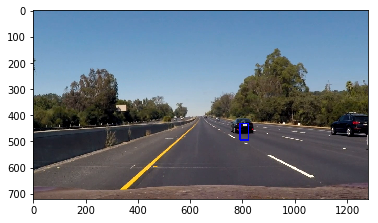

In [26]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

bboxes_list = []

video = VideoFileClip("project_video.mp4")
project_clip = video.fl_image(process_image) #NOTE: this function expects color images!!
video_output = "output_v5.mp4"
%time project_clip.write_videofile(video_output, audio=False)

print("Bounding boxes: ", bboxes_list)

In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))